# XGBoost to predict discharge disability
Using all features, with a 5-fold cross validation, train a multiclass classification model to give the probability (likelihood) that each patient is in each discharge disability class (mRS 0, 1, 2, 3, 4, 5 or 6)

### Plain English summary

Before look at feature selection, let's look at the performance of a model trained on all of the data. Use 5 k-fold splits. Also analyse the consistency of the results for these five different data divisions.

### Model and data
Model: XGBoost classifier (multiclass classification)\
Target feature: Discharge disability\
Input features: All the relevant features in SSNAP\
Kfold split: 5 kfold split

### Aims
What's the performance of a model using all of the available features?  Look at accuracy in terms of:
1. Accuracy (i. % correct, ii. % within one correct)
1. Confusion matrix
1. ROCAUC

Other assessments of performance:
1. Calibration and assessment of accuracy when model has high confidence
1. Reliability

Is model performance (and patterns detected) dependent on the data divisions in the k-fold splits?

### Observations
Model performance (and patterns detected) are reasonably consistent across the 5 k-fold splits.

#### Further work

Calculate feature importance and SHAP values for these models.

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

(code orignially from 01a_xgb_kfold_all_features_accuracy_importance_shap.ipynb and 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb)


## Import libraries

In [65]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from dataclasses import dataclass

import pickle
import shap

from os.path import exists

import math

import time
import datetime

Report the time duration to run notebook

In [66]:
start_time = time.time()

Choose number of kfolds (either =1 for the first kfold, or =5 for the full 5 kfold split)

In [67]:
n_kfold = 5

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [68]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_all_features_{n_kfold}fold'
    notebook: str = '010_'

paths = Paths()

Create output folders if needed

In [69]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

Some features need to be removed from the dataset (those that are duplicates). Define a function to do this.

In [70]:
def drop_columns(df, cols):
    """
    For the dataframe, remove the columns 'cols' if they are present
    
    Args:
        df [dataframe]: The feature values per patient
        cols [list]: The features to remove if present

    Return:
        df [dataframe]: The feature values per patient without specified columns
    """
    for col in cols:
        if col in df.columns: df.drop([col], axis=1, inplace=True)
    return(df)

Specify the columns to remove

In [71]:
cols_remove = ['id','stroke_team_id']

## Import data

Data has previously been split into 5 stratified k-fold splits. Read these in.

In [72]:
train_data_kfold, test_data_kfold = [], []

for k in range(n_kfold):
    # Read in training set, restrict to chosen features, rename titles, & store
    filename = os.path.join(paths.data_read_path, 
                            ('03_train_' + str(k) + '.csv'))
    train = pd.read_csv(filename)
#    train.rename(columns=dict_feature_name, inplace=True)
    train = drop_columns(train, cols_remove)
    train_data_kfold.append(train)

    filename = os.path.join(paths.data_read_path, 
                            ('03_test_' + str(k) + '.csv'))
    test = pd.read_csv(filename)
#    test.rename(columns=dict_feature_name, inplace=True)
    test = drop_columns(test, cols_remove)
    test_data_kfold.append(test)

Select the features for the model

In [73]:
selected_features = list(train_data_kfold[0])
selected_features.remove('discharge_disability')
n_features = len(selected_features)
selected_features.append('discharge_disability')

Limit dataset to selected features (in this case, we are keeping all the available features, the previous cell may specify otherwise for another purpose)

In [74]:
for k in range(n_kfold):
    train = train_data_kfold[k]
    train = train[selected_features]
    train_data_kfold[k] = train

    test = test_data_kfold[k]
    test = test[selected_features]
    test_data_kfold[k] = test

Store the output classes

In [75]:
class_names = train_data_kfold[0]['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

Take copy of stroke team to use to create a histogram (before this feature is converted into a one hot encoded feature)

In [76]:
test_stroke_team_kfold = (
                 [test_data_kfold[k]["stroke_team"] for k in range(n_kfold)])

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [77]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [78]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [79]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        for k in range(n_kfold):
            train_data_kfold[k] = (
              convert_feature_to_one_hot(train_data_kfold[k], feature, prefix))
            test_data_kfold[k] = (
              convert_feature_to_one_hot(test_data_kfold[k], feature, prefix))

Feature names with one hot encoding

In [80]:
features_ohe = list(train_data_kfold[0])
features_ohe.remove("discharge_disability")
n_features = len(features_ohe)

In [81]:
print(f"There are {len(selected_features)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 55 original features (before one-hot encoding)
There are 177 features (after one-hot encoding)


## Fit XGBoost model

Train model with all features to predict the disability of each patient at discharge. This is a multiclass classification model, where each patient is given a probability of begin in each of the classes. For our case, for the individual mRS levels.

This model will be the same as trained in notebook 020_xgb_feature_selection.ipynb (that is used for comparison with the feature selection models)

Create function to return X and y data for train and test sets

In [82]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    Args:
        train [dataframe]: dataframe containing training instances 
        test [dataframe]: dataframe containing test instances
        target [string]: column name of the targert feature (the column to separate 
                        from the two dataframes)

    Returns:
        X_train [dataframe]: dataframe containing input features for the 
                            training instances 
        X_test [dataframe]: dataframe containing target feature for the training 
                            instances 
        y_train [dataframe]: dataframe containing input features for the 
                             training instances 
        y_test [dataframe]: dataframe containing target features for the 
                            training instances 
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Create function to get xgboost model (either load if file exists, else train)

In [83]:
def xgboost_model(filename, X_train, y_train):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                              tree_method='gpu_hist')
        model.fit(X_train, y_train)

        # Save using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)
    return(model)

In [84]:
# Initiate lists
r_square_kfold = []
roc_auc_ovr_kfold = []
accuracy_kfold = []
error_within_one_kfold = []
feature_importance_kfold = []
y_probs_kfold = []
y_pred_kfold = []
model_kfold = []

# Loop through k folds
for k in range(n_kfold):

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                    (paths.notebook + paths.model_text + '_' + str(k) + '.p'))
    
    model = xgboost_model(filename, X_train, y_train)
    model_kfold.append(model)

    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_kfold.append(y_probs)

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_kfold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_kfold.append(error_within_one)

## Section 1: Accuracy

#### Section 1.1 Accuracy (average and consistency across k-folds)
i. % correct\
ii. % within one correct

In [85]:
accuracy_mean = np.mean(accuracy_kfold)
error_within_one_mean = np.mean(error_within_one_kfold)

print (f'All features, accuracy: {accuracy_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(accuracy_kfold):0.3f})')

print (f'All features, accuracy within one: {error_within_one_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(error_within_one_kfold):0.3f})')

All features, accuracy: 0.441 (std across 5 kfolds: 0.002)
All features, accuracy within one: 0.759 (std across 5 kfolds: 0.002)


#### Section 1.2 Confusion matrix (across the kfolds)

Resource (subplots with imshow): https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar

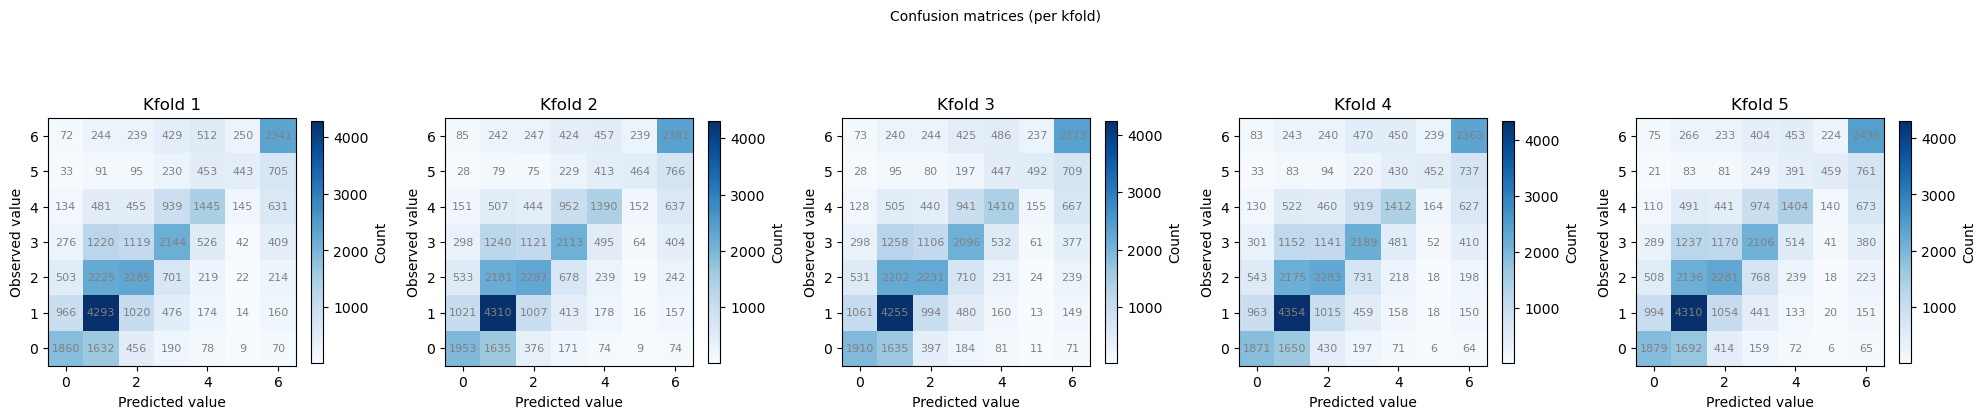

In [86]:
# Define number subplots for the figure
nrows = 1
ncols = n_kfold

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

if ncols > 1:
    fig.suptitle('Confusion matrices (per kfold)', fontsize=10)

# Set figure width (relative to the number of kfolds)
width = 20 * (n_kfold/5)
fig.set_size_inches(width,5)

# Legend height
shrink = 0.5

# Initialise indices for the subplots
row = 0
col = 0

# Loop through the kfolds, create a subplot per kfold (of a confusion matrix)
for k, ax in zip(range(n_kfold), axs):

    # Set axis title
    ax.set_title(f'Kfold {k+1}')

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')
    # Calculate values for confusion matrix
    cm = confusion_matrix(y_test, y_pred_kfold[k])

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    # Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)

    # Set axis titles
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

    # Move to the next subplot
    col += 1
    # Move to the next row if exceed number of columns
    if col == ncols: 
        col = 0
        row += 1

plt.tight_layout()

# Make space for title
plt.subplots_adjust(top=1)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_confusion_matrices_per_kfold.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

#### Section 1.3 ROC AUC for multiclass model

Calculate the overall ROC AUC for multiclass classification (a value per k-fold model)

In [87]:
roc_auc_ovr_mean = np.mean(roc_auc_ovr_kfold)
print (f'ROCAUC (mean of {n_kfold} k-folds): {roc_auc_ovr_mean:0.3f}')
print (f'ROCAUC (std across {n_kfold} kfolds): {np.std(roc_auc_ovr_kfold):0.3f})')
print (f'ROCAUC (per kfold): {roc_auc_ovr_kfold}')

ROCAUC (mean of 5 k-folds): 0.817
ROCAUC (std across 5 kfolds): 0.001)
ROCAUC (per kfold): [0.8174398640018434, 0.8174841238144157, 0.8165538003307189, 0.8170277419360081, 0.8185656534265624]


To calculate the ROC AUC for a multiclass classification model, we use functions that are slightly modified from the binary classifier case.

For this case the ROC AUC is calculated for each pair-wise selection of the classes, and treating this as a binary model (in a way), and so using the usual method to calculate the ROC AUC. The whole model ROC AUC is taken as the average across all pair-wise comparisons.

This is known as the one vs one method.

The other option is the one vs rest method. For each class it then groups the others as "the rest", and treats that as the binary split for the classic ROC AUC calculation. Taking the average across these 6 comparisons (one per class) gives the ROC AUC for the whole model.

We can observe the ROC AUC plot (and histograms) for each class. And for each kfold model.

The histograms show the range of probabilities for being a specific class for 1) the patients that are that class 2) the patients that are not that class.
For OvO the patients that are not that class are for a single other class.
For OvR the patients that are not that class are for all of the other classes.

Resources:

https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb

In [88]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) 
    based on real and predicted observations
    
    Args:
        y_real [list or series]: The list or series with the real classes
        y_pred [list or series]: The list or series with the predicted classes
        
    Returns:
        tpr [float]: The True Positive Rate of the classifier
        fpr [float]: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return (tpr, fpr)

In [89]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each 
    point as a threshold for the predicion of the class.
    
    Args:
        y_real [list or series]: The list or series with the real classes.
        y_proba [array]: The array with the probabilities for each class, 
                    obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list [list]: The list of TPRs representing each threshold.
        fpr_list [list]: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    return (tpr_list, fpr_list)

In [90]:
def plot_roc_curve(tpr, fpr, scatter=True, ax=None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr [list]: The list of TPRs representing each coordinate.
        fpr [list]: The list of FPRs representing each coordinate.
        scatter [boolean]: When True, the points used on the calculation will be 
                    plotted with the line (default = True).
        ax [object]: matplotlib ax object

    Returns:
        None
    '''
    
    if ax == None:
        plt.figure(figsize=(5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x=fpr, y=tpr, ax=ax)
    sns.lineplot(x=fpr, y=tpr, ax=ax)
    sns.lineplot(x=[0, 1], y=[0, 1], color='green', ax=ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    return()

ROC Curve - One vs Rest (OvR)

Compares each class with the rest of the classes

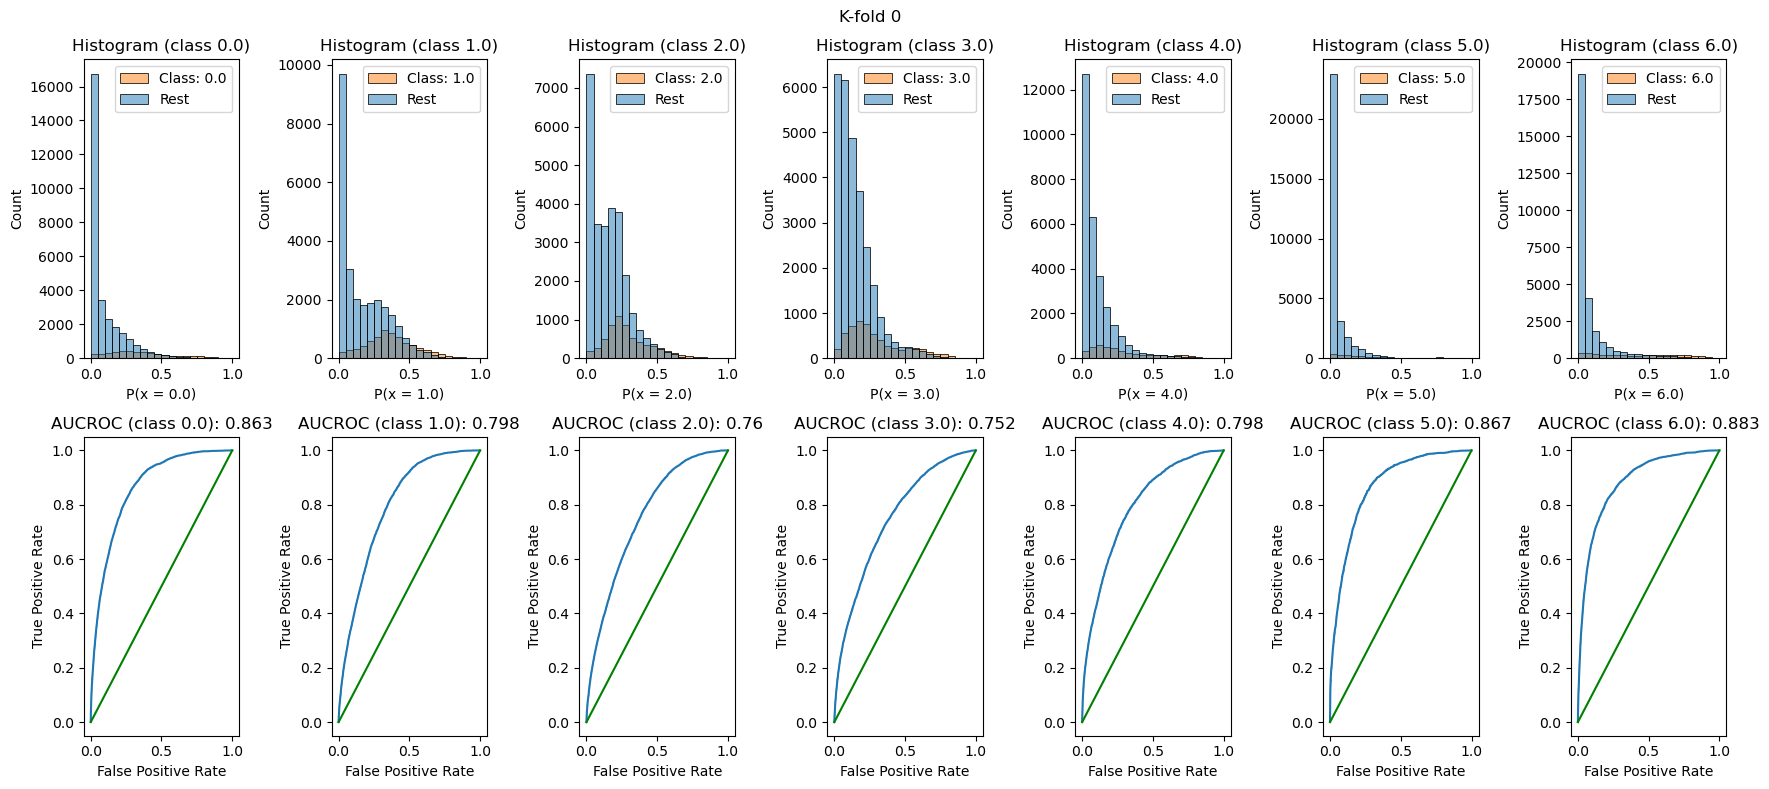

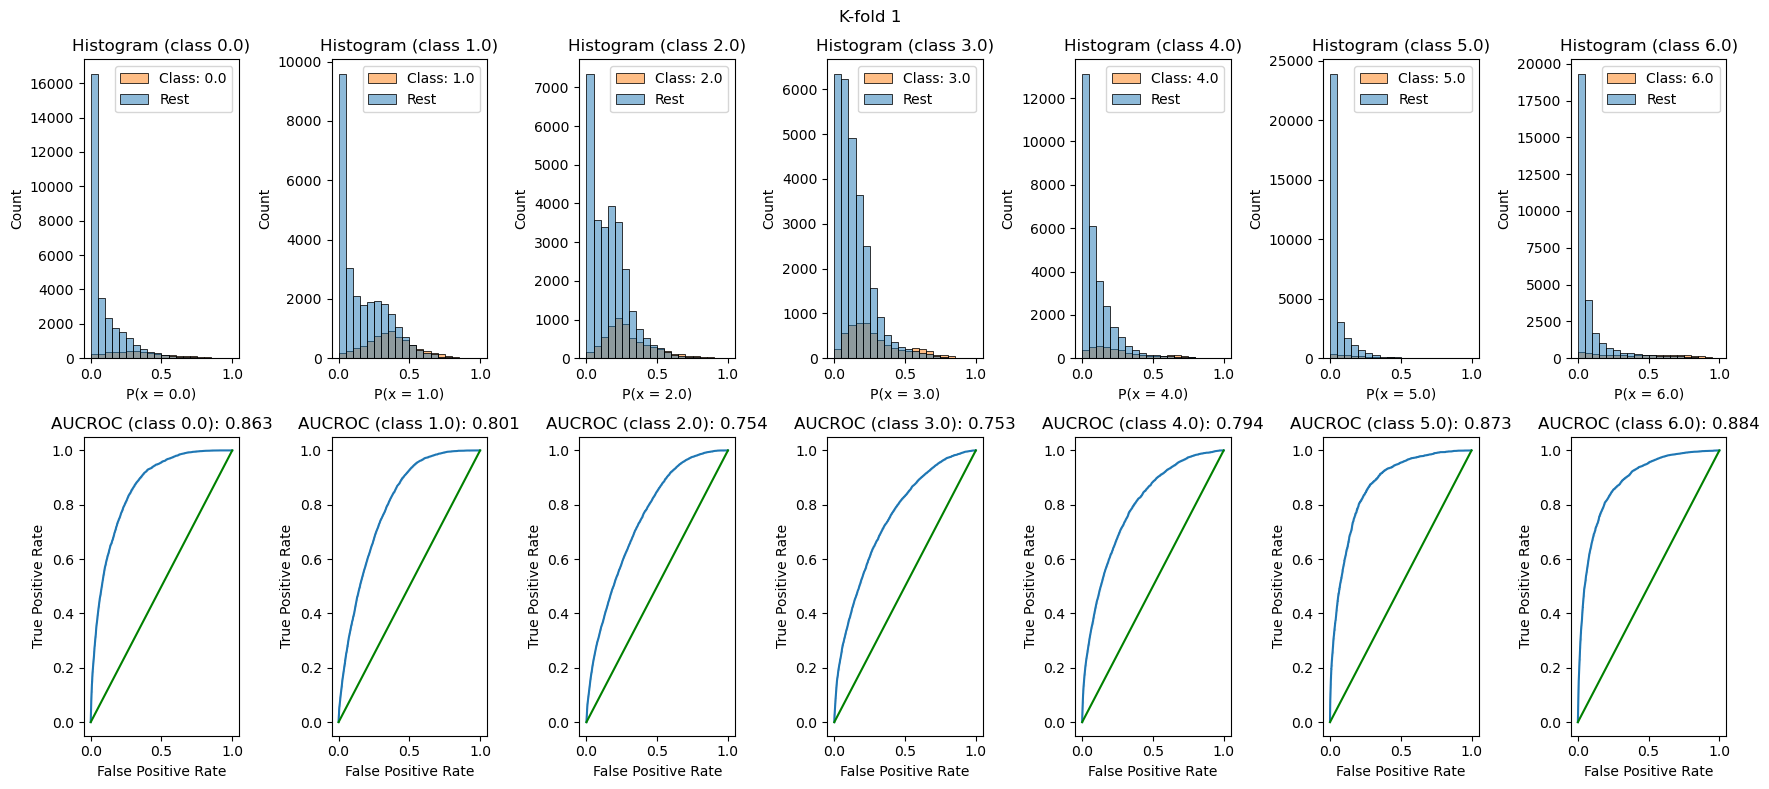

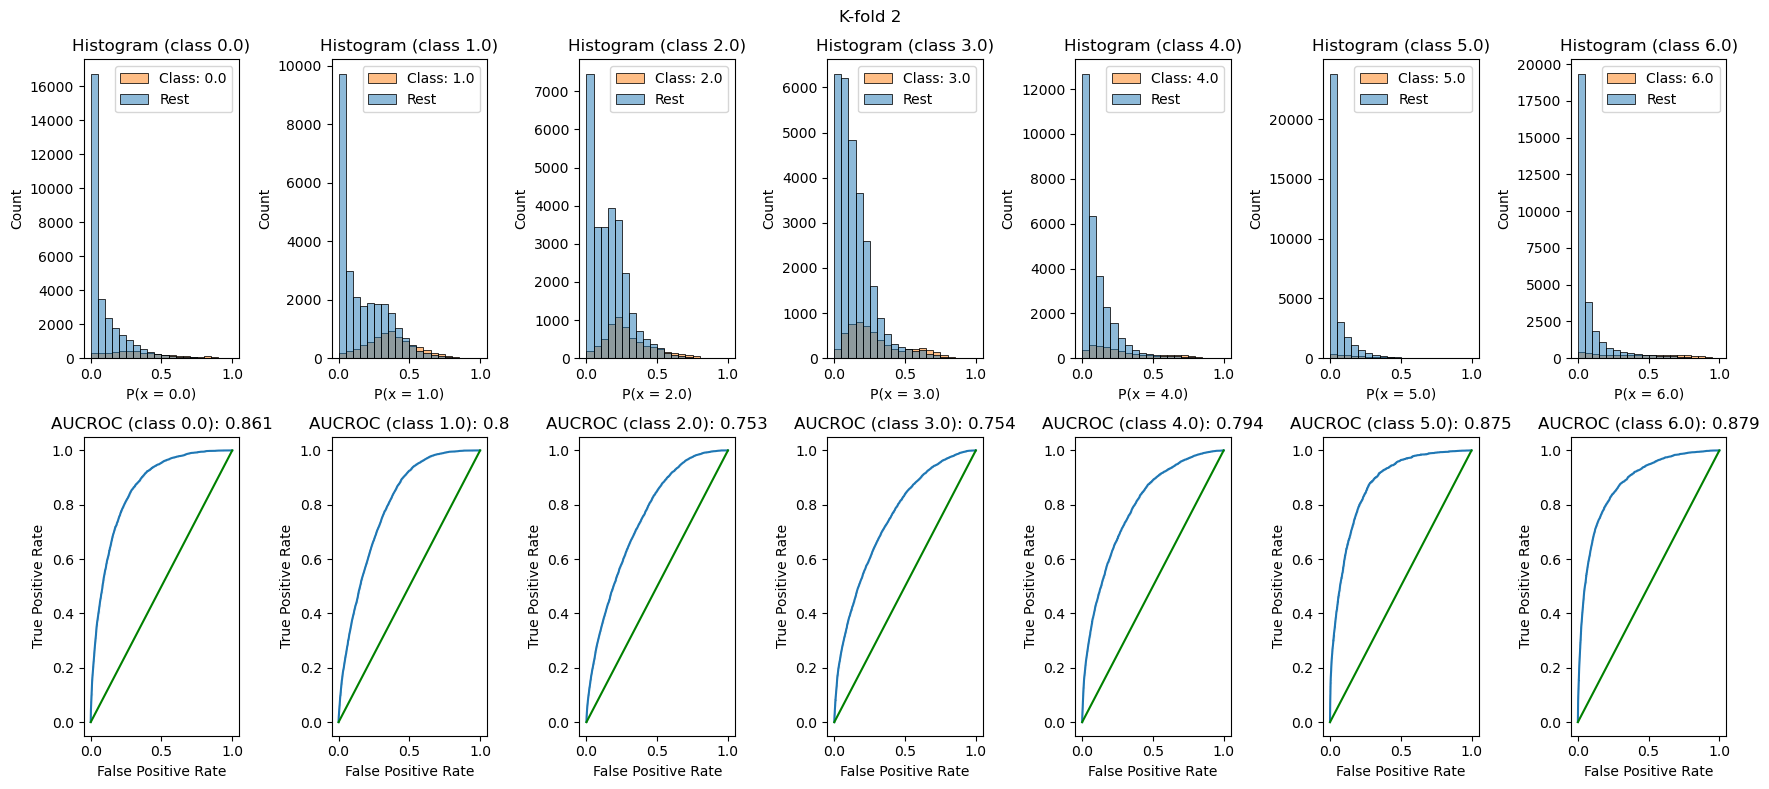

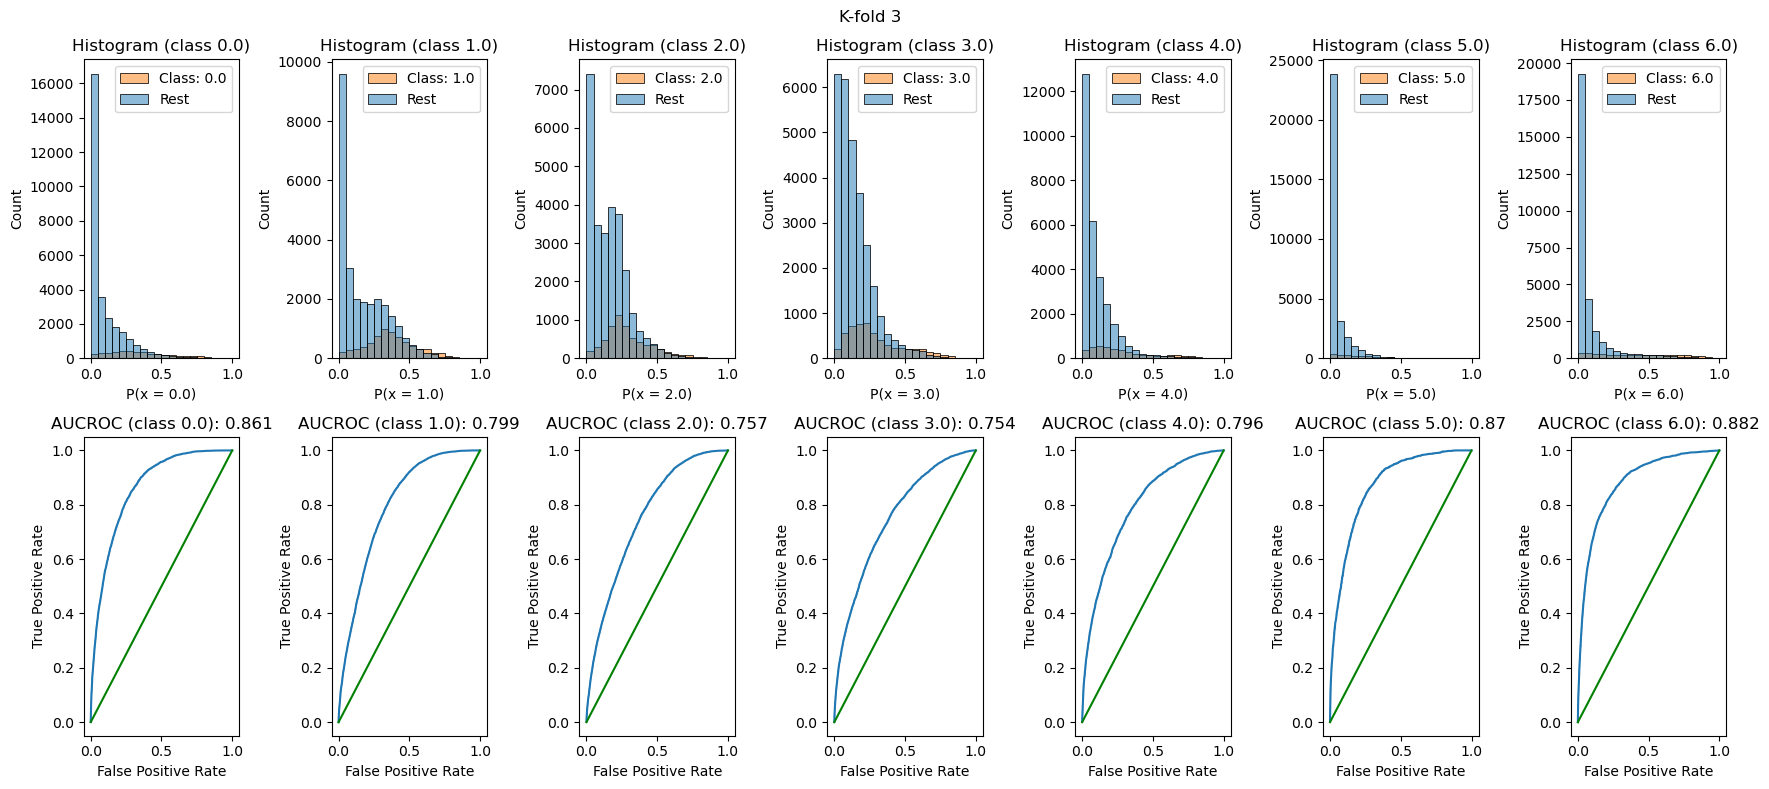

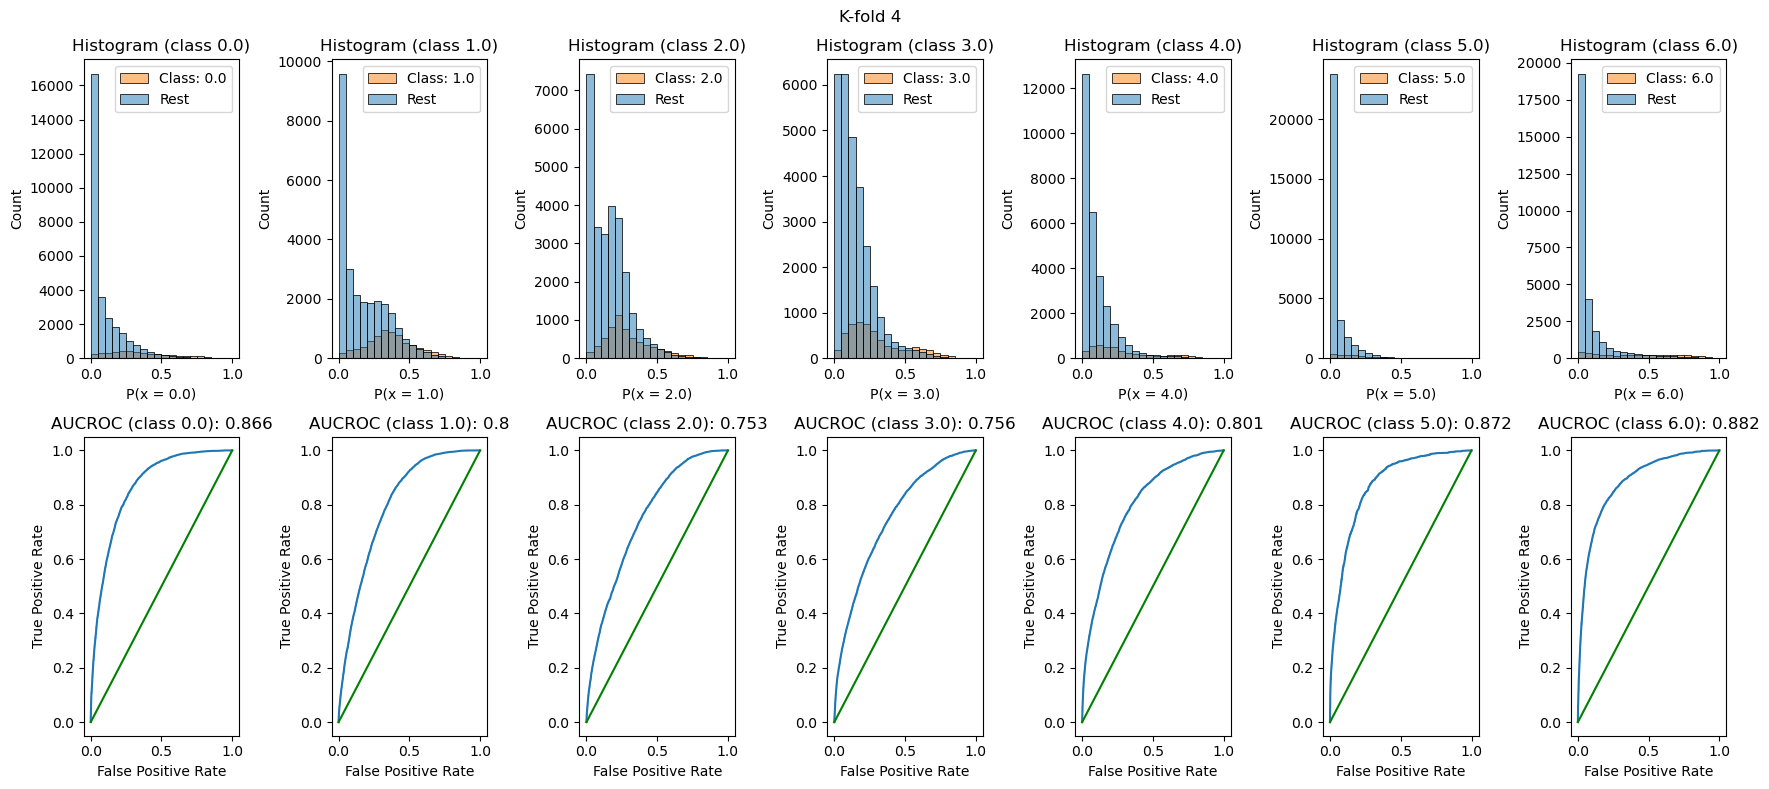

In [91]:
classes = model.classes_

bins = [i/20 for i in range(20)] + [1]

# figure width to change with number of classes
width = 15 * (len(classes)/6)

# Create a figure per kfold
for k in range(n_kfold):
    # Plots the Probability Distributions and the ROC Curves One vs Rest
    fig = plt.figure(figsize = (width, 8))
    fig.suptitle(f'K-fold {k}')
    roc_auc_ovr = {}

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # With a subplot for each class
    for i in range(len(classes)):

        # Gets the class
        c = classes[i]
        
        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_probs_kfold[k][:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, len(classes), i+1)
        sns.histplot(x="prob", data=df_aux, hue='class', color='b', 
                     ax=ax, bins=bins)
        ax.set_title(f'Histogram (class {c})')
        ax.legend([f"Class: {c}", "Rest"])
        ax.set_xlabel(f"P(x = {c})")
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, len(classes), i+len(classes)+1)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter=False, ax=ax_bottom)
        ax_bottom.set_title(
                    f'AUCROC (class {c}): {round(roc_auc_ovr[c],3)}')
        
    plt.tight_layout()

    # Save
    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + '_rocauc_ovr_kfold_' + str(k) + '.jpg')) 
    plt.savefig(filename, dpi=300)
    plt.show()


Here we show the exact same results, instead this time each set of subplots shows the same class for all kfolds (rather above shows the set of subplots for each of the classes in the same kfold)

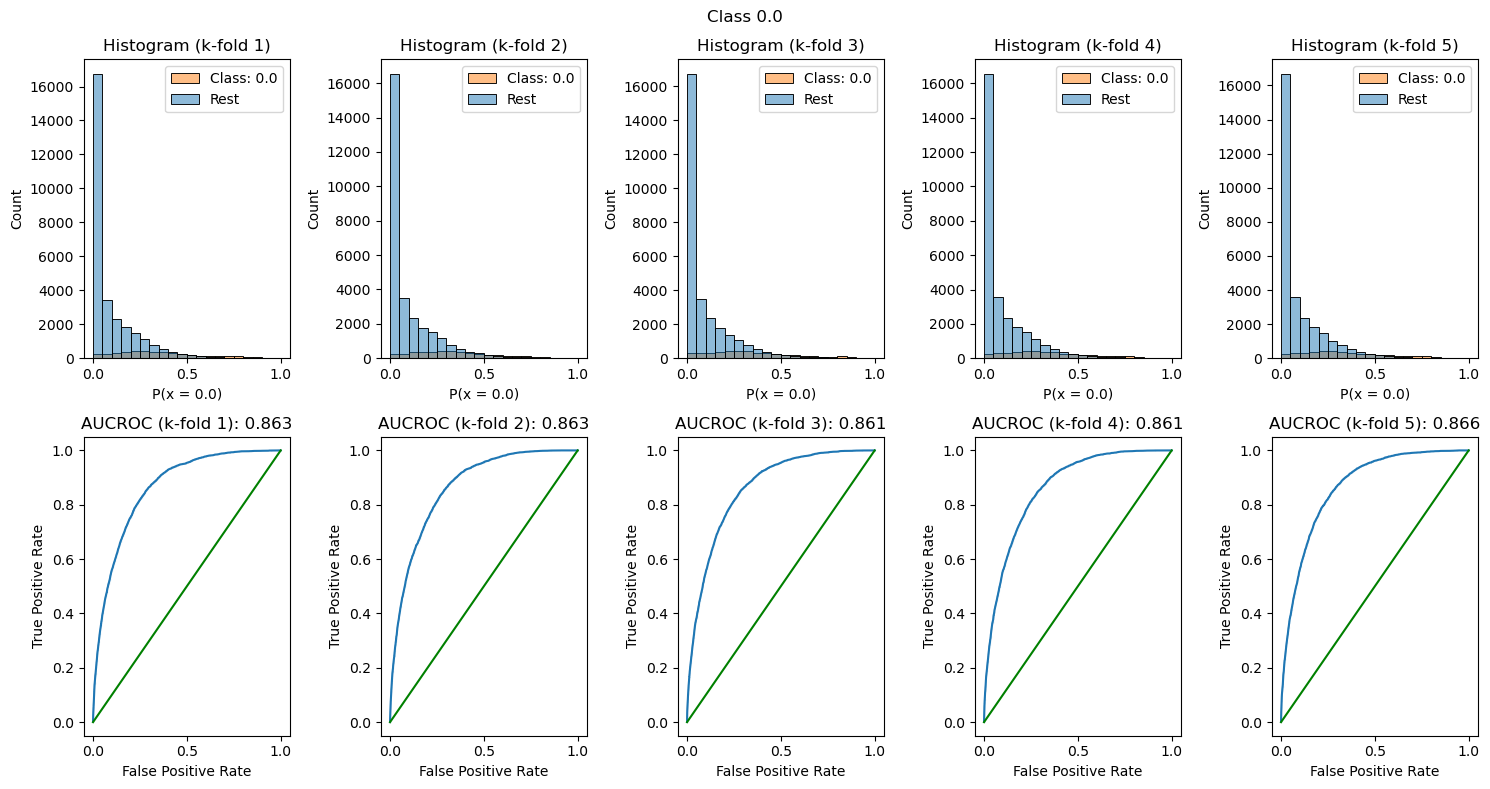

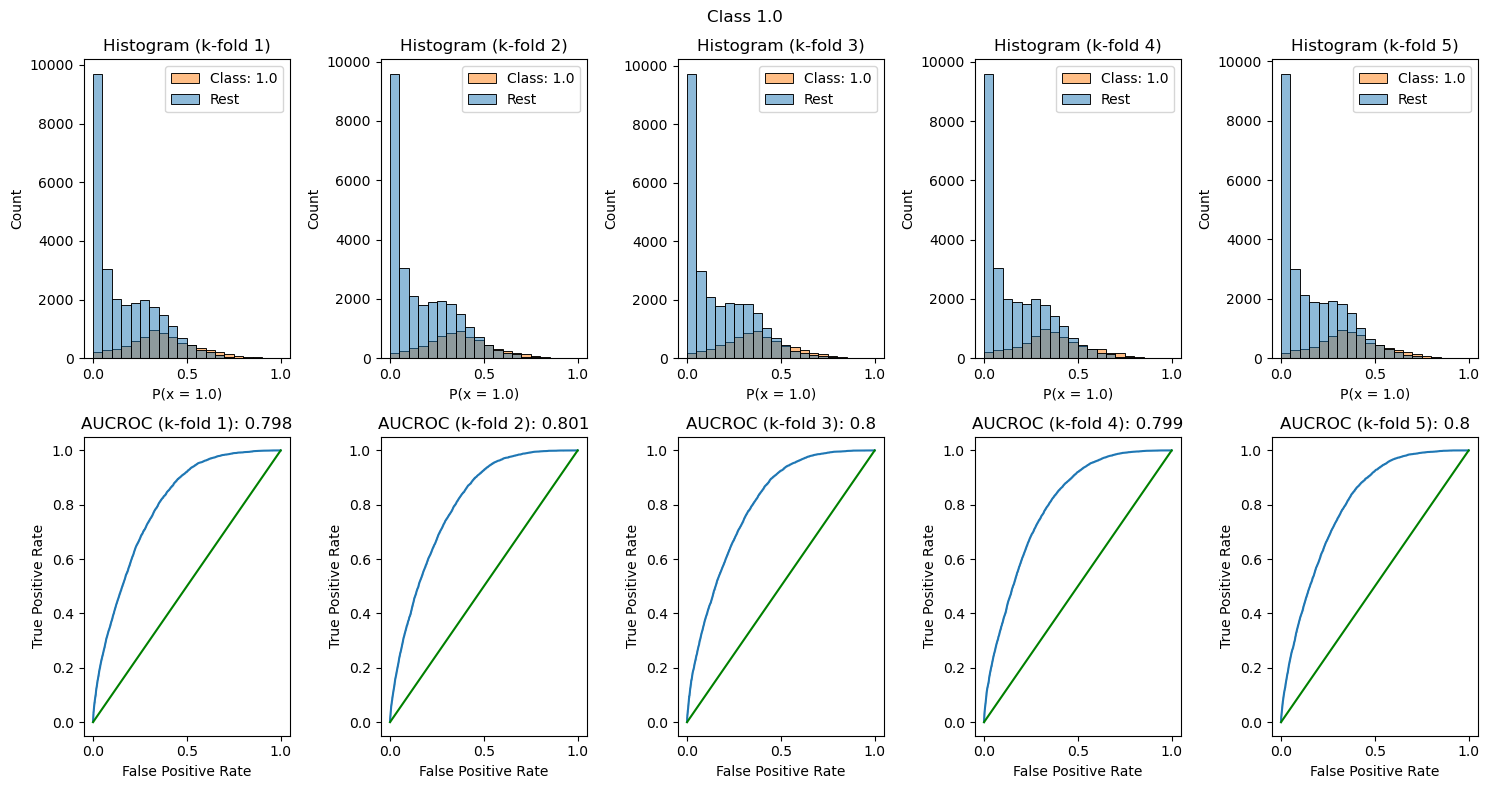

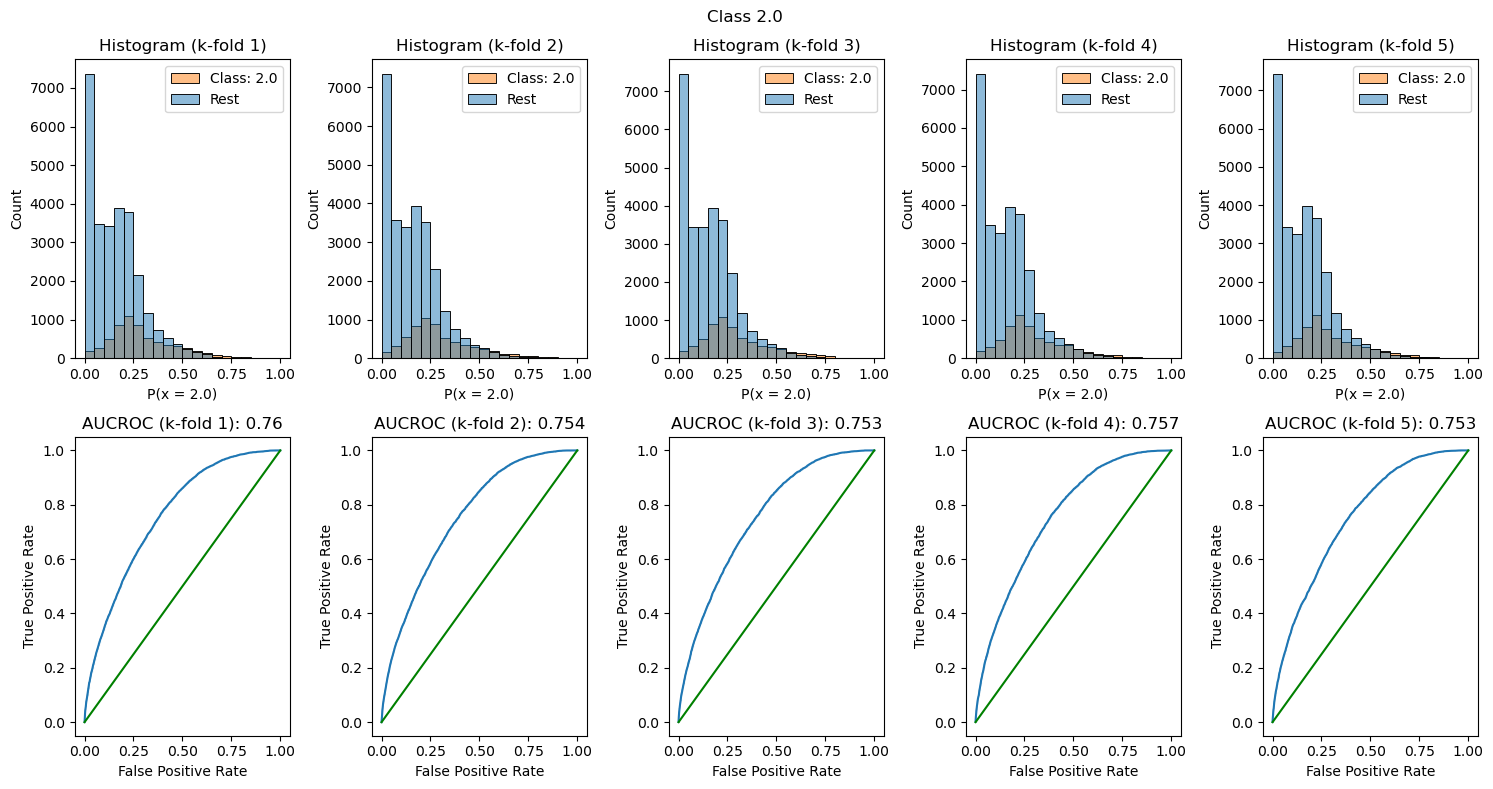

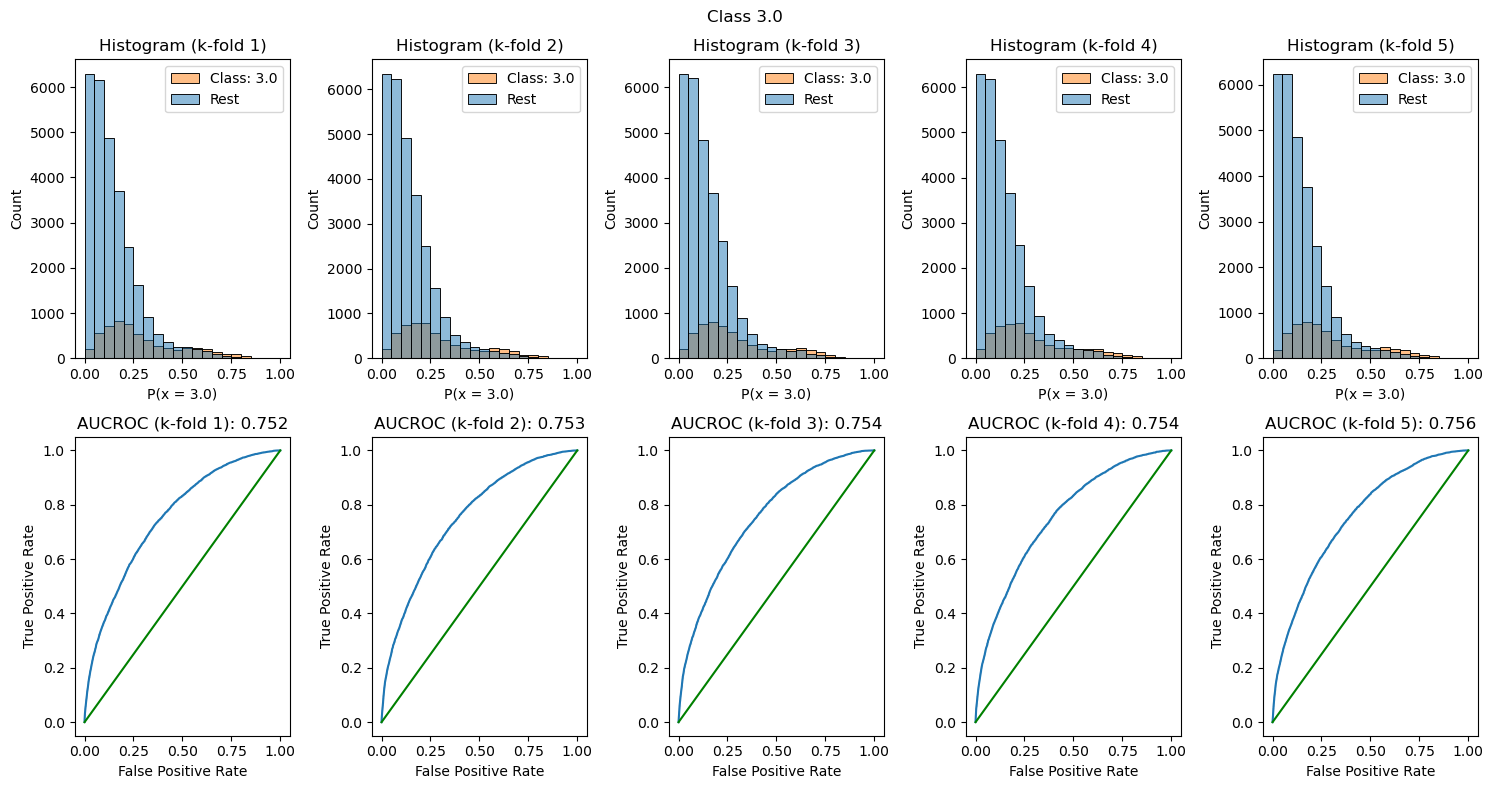

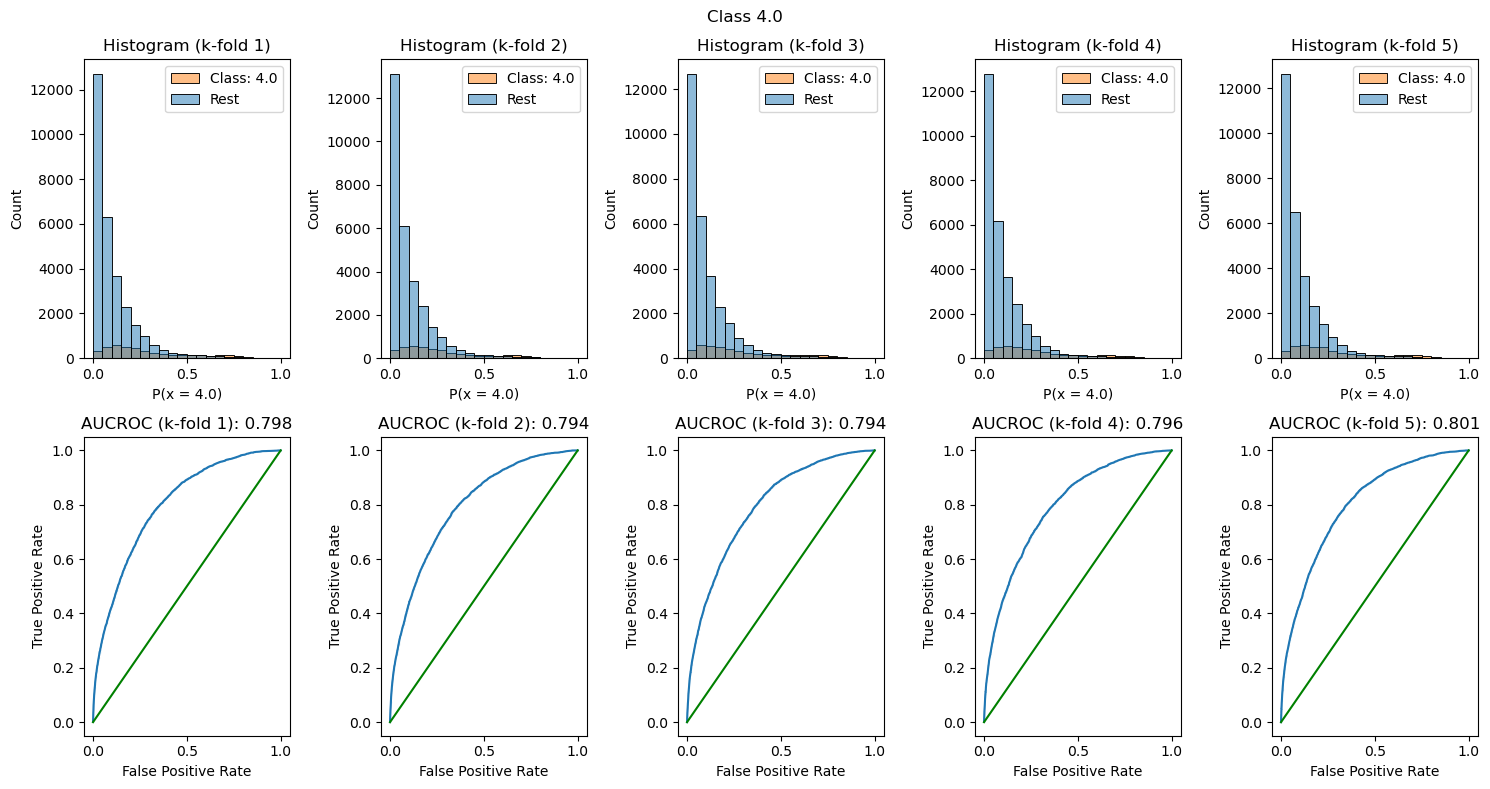

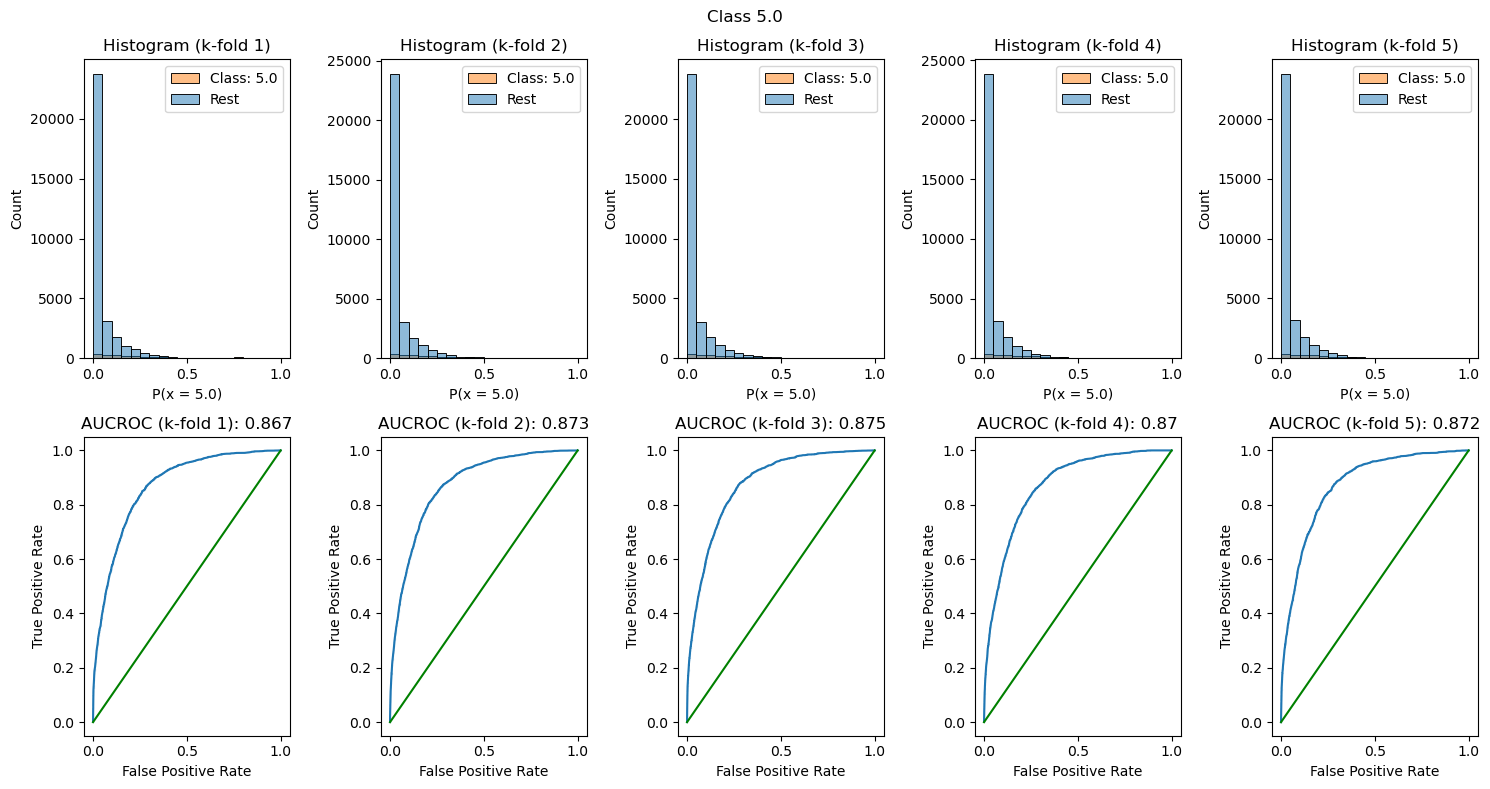

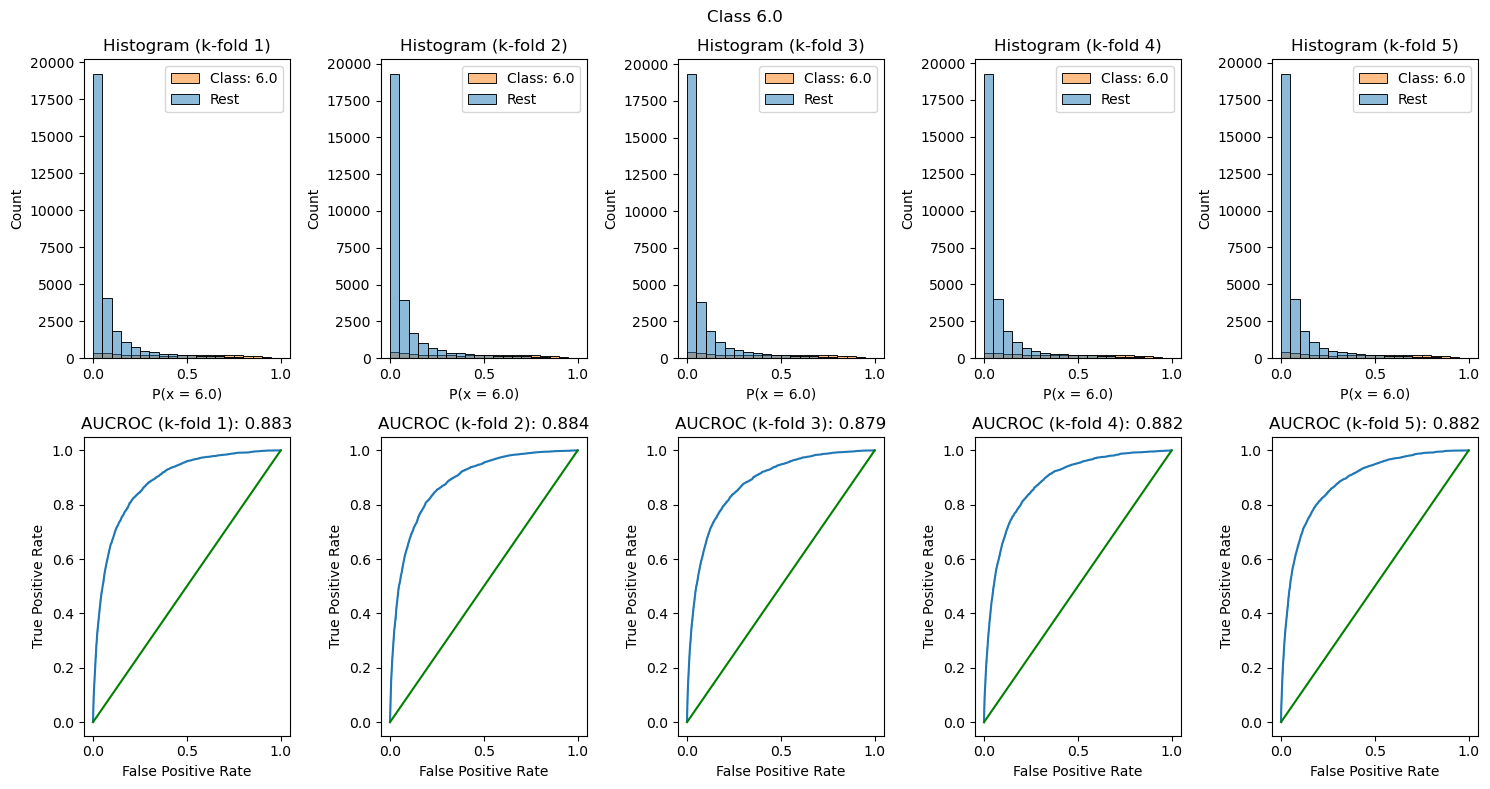

In [92]:
classes = model.classes_

bins = [i/20 for i in range(20)] + [1]

# figure width to change with number of kfolds
width = 15 * (n_kfold/5)

# Create a figure per class
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Plots the Probability Distributions and the ROC Curves One vs Rest
    fig = plt.figure(figsize = (width, 8))
    fig.suptitle(f'Class {c}')
    roc_auc_ovr = {}

    # With a subplot for each kfold
    for k in range(n_kfold):
        
        # Get k fold split
        (X_train, X_test, y_train, y_test) = get_x_y_data(
                                                    train_data_kfold[k],
                                                    test_data_kfold[k],
                                                    'discharge_disability')
        
        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_probs_kfold[k][:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Calculates the ROC AUC OvR
        roc_auc_ovr[k] = roc_auc_score(df_aux['class'], df_aux['prob'])

        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 5, (k + 1))
        sns.histplot(x="prob", data=df_aux, hue='class', color='b', 
                     ax=ax, bins=bins)
        ax.set_title(f'Histogram (k-fold {k+1})')
        ax.legend([f"Class: {c}", "Rest"])
        ax.set_xlabel(f"P(x = {c})")
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 5, (k + 1 + n_kfold))
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter=False, ax=ax_bottom)
        ax_bottom.set_title(
                    f'AUCROC (k-fold {k+1}): {round(roc_auc_ovr[k],3)}')
        
    plt.tight_layout()

    # Save
    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + '_rocauc_ovr_class_' + str(c) + '.jpg'))
    plt.savefig(filename, dpi=300)
    plt.show()


To interpret the above plots, think of the model as having 7 separate parts, each giving the probability of classifying an instance as each class (0, 1, 2, 3, 4, 5, 6).

These charts look at the performance of each of the model parts in isolation.

Left hand graph: Showing the probability of the model classifying an instance as class 0, for all of the instances that are a 0 (orange), for all the instances that are not 0 (blue). The blues are made up of the classes 1, 2, 3, 4, 5, 6.

Right hand graph: Showing the probability of the model classifying an instance as class 6, for all of the instances that are a 6 (orange), for all the instances that are not 6 (blue). The blues are made up of the classes 0, 1, 2, 3, 4, 5.

The model does not use a set threshold to determine the classification from a single graph (as in a binary label model). It instead classifies instances based on the class that has the maximum probability for that instance.

Therefore, for the LHS graph we can not know which of the instances end up getting a class 0 classification, as the threshold will differ for each instnace. So an orange point with 0.3 probability may get a 0 classification, and another orange point with 0.3 probability may not get a 0 classification.

Using ROC AUC to choose the features means we are choosing the feature which best differentiates each class from the others (a mean across all classes). It is not showing a model that has the best prediction (as it is not comparing the probabilities across the 7 classes).

The blue histogram in the OvR graphs represents the other 6 classes. When perform OvO the orange distribution is the same across all the graphs, but the blue is filtered to show just one of the other classes. Summing up all the OvR blue bits will give the OvO graph.

(see end of notebook for analysis using OvO)

## Section 2: Calibration and assessment of accuracy when model has high confidence.

To test for callibration, look at each output classification separately, take all of the instances and group them based on the probability for that classification as given by the model. See how many are that classification. 
For example, all of the instances that the model gives a probability in the range 0.2 to 0.3, in a well callibrated model between 0.2 to 0.3 of these instances would be this category). 

For a multiclass classification model, we calculate the calibration for each class.

Need to get the probability for the true category per instance.

Define function to plot line per kfold data in dataframe

In [93]:
def plot_fraction_positive(df_reliability, c, ax, n_kfold, 
                           title_text=""):
    """
    Plots the confidence vs fraction positive, with a 1:1 line.

    Args:
        df_reliability [dataframe]: Contains 3 columns per bin
        c [string]: The classification category (used in the plot title)
        ax [matplotlib axis object]: matplotlib axis object
        n_kfold [integer]: Number of kfolds
        title_text [string]: Text to add to the plot title

    Return:
        ax [matplotlib axis object]: matplotlib axis object
    """

    # Add 1:1 line
    ax.plot([0,1],[0,1], color='grey', linestyle ='--')

    # Want to view the individual kfolds
    # Loop through k-fold reliability results
    for k in range(n_kfold):
        # Get values for the kfold
        mask = df_reliability['k-fold'] == k
        result_kfold = df_reliability[mask]
        # Plot the confidence vs fraction positive
        x = result_kfold['confidence']
        y = result_kfold['fraction_positive']
        ax.plot(x, y, color='k', alpha=0.6)


    # Refine plot
    ax.set_xlabel('Model probability', fontsize=9)
    ax.set_ylabel('Fraction positive', fontsize=9)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Predicting mRS{round(c)}\n{title_text}', fontsize=9)

    return(ax)

In [94]:
def plot_fraction_positive_average(df_reliability_mean_kfolds, c, ax, 
                                   title_text=""):
    """
    Plots the confidence vs fraction positive (mean of the kfolds), with a 
    1:1 line.

    Args:
        df_reliability_mean_kfolds [dataframe]: Contains 3 columns per bin
        c [string]: The classification category (used in the plot title)
        ax [matplotlib axis object]: matplotlib axis object
        title_text [string]: Text to add to the plot title

    Return:
        ax [matplotlib axis object]: matplotlib axis object
    """

    # Add 1:1 line
    ax.plot([0,1],[0,1], color='grey', linestyle ='--')

    # Calculate mean and standard error across the 5 kfolds in new dataframe,
    # for both the x and y
    reliability_overview = pd.DataFrame()

    reliability_overview['confidence_mean'] = \
        df_reliability_mean_kfolds.groupby('bin_nominal').mean()['confidence']

    reliability_overview['confidence_stddev'] = \
        df_reliability_mean_kfolds.groupby('bin_nominal').std()['confidence']

    reliability_overview['confidence_stderr'] = \
        reliability_overview['confidence_stddev']/math.sqrt(5)

    reliability_overview['fraction_positive_mean'] = \
        df_reliability_mean_kfolds.groupby('bin_nominal').mean()['fraction_positive']

    reliability_overview['fraction_positive_stddev'] = \
        df_reliability_mean_kfolds.groupby('bin_nominal').std()['fraction_positive']

    reliability_overview['fraction_positive_stderr'] = \
        reliability_overview['fraction_positive_stddev']/math.sqrt(5)

    x = reliability_overview['confidence_mean']
    y = reliability_overview['fraction_positive_mean']
    xerr = reliability_overview['confidence_stderr']
    yerr = reliability_overview['fraction_positive_stderr']

    ax.errorbar(x, y, yerr=yerr, xerr=xerr, color='k', alpha=0.8)

    # Refine plot
    ax.set_xlabel('Model probability', fontsize=9)
    ax.set_ylabel('Fraction positive', fontsize=9)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Predicting mRS{round(c)}\n{title_text}', fontsize=9)

    return(ax)

In [95]:
def plot_fraction_instances(reliability_collated, ax, n_kfold):
    """
    Plots the confidence vs fraction of instances, with a 1:1 line.

    Args:
        reliability_collated [dataframe]: Contains 3 columns per bin
        ax [matplotlib axis object]:  
        n_kfold [integer]: Number of kfolds

    Return:
        ax [matplotlib axis object]: matplotlib axis object
    """

    # Loop through k-fold reliability results
    for k in range(n_kfold):
        # Get values for the kfold
        mask = reliability_collated['k-fold'] == k
        result_kfold = reliability_collated[mask]
        # Plot the confidence vs fraction positive
        x = result_kfold['confidence']
        y = result_kfold['fraction_results']
        ax.plot(x,y, color='blue')

    # Refine plot
    ax.set_ylabel('Fraction of instances', fontsize=9, color='blue')
    ax.tick_params(axis='y', color='blue')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    return(ax)        


Define function to create the dataframe df_reliability

In [96]:
def create_df_reliability(digitized, prob_observed,
                          observed_binary, classification, observed, c):
    """
    The values passed in will be for a certain kfold, for a certain class output
    and using a set bin range.

    Put values into a dataframe (contains data for each patient per row. This 
    data is for a certain kfold and the probability for a certain output class.
    A range of bins has already been defined.
    Here record which bin range each patient falls into ('bin'), the probability 
    the model gave ('prob_observed') to be in this class ('c').
    'observed_binary' is whether this patient is a class 'c'
    'observed_class' is the class the patient really is
    'classification' is the class that the patient would be allocated (from the 
            model - the class with the highest probability)
    'correct_binary' is whether the binary model got it right (T/F about this 
            class)
    'correct_class' is whether the full model got it right (correct class 
            allocated by full model)
    'count' set to 1 for each patient (1 patient)
    'class' this model part is predicting the probability to be this specific 
            class
   
    Args:
        digitized [series]: bin ranges
        prob_observed [series]: probability of the observed
        observed_binary [series]: Is the patient this class
        classification [series]: is the class that the patient would be 
                allocated (the class with the highest probability from the model)
        observed [series]: the observed class of the patient
        c [integer]: Data is about this class

    Return:
        df [dataframe]: containing data for a kfold, the probability for a 
                        certain class

    """
    df = pd.DataFrame()
    df['bin'] = digitized
    df['probability_observed'] = prob_observed
    df['observed_binary'] = observed_binary
    df['observed_class'] = observed
    df['classification'] = classification
    df['correct_binary'] = observed_binary == classification
    df['correct_class'] = observed == classification
    df['count'] = 1
    df['class'] = c

    return(df)

Define function to group data in dataframe by value in column "bins"

In [97]:
def group_data_by_bins(bins, k, df_reliability):
    """
    Create a dataframe that contains the bins ('bin_nominal' is just a label for 
    each range, using a continuous value from 1 to n)
    Store the kfold this is for (this is called for each kfold)
    'confidence' contains the proportion correct within each bin (of the 
    observed cases)
    'fraction positive' proportion of patients in the class (a well calibrated 
    model has the same proportion correct as the bin of the probability)

    Args:
        bins [series]: range of bins
        k [integer]: the kfold
        df_reliability [dataframe]: contains data for each patient per row. This 
            data is for a certain kfold and the probability for a certain output 
            class. A range of bins has already been defined.
    
    Return:
        df [dataframe]: for each bin (and which kfold) store the 'confidence' 
            (contains the proportion correct within each bin, and the
            'fraction positive' (proportion of patients in the class)

    """
    df = pd.DataFrame()

    # Add bins and k-fold to summary
    df['bin'] = bins
    df['bin_nominal'] = np.array(range(len(bins)))
    df['k-fold'] = k

    # Calculate mean of predicted probability of correct category in each bin
    df['confidence'] = \
        df_reliability.groupby('bin').mean()['probability_observed']

    # Calculate the proportion of patients in this class
    df[f'fraction_positive'] = \
        df_reliability.groupby('bin').mean()['observed_binary']

    # Calculate proportion correct in each bin
    df['fraction_correct'] = \
        df_reliability.groupby('bin').mean()['correct_class']

    # Calculate fraction of results in each bin
    df['fraction_results'] = \
        df_reliability.groupby('bin').sum()['count'] / df_reliability.shape[0]

    return(df)

Define function to define the bins (based on bin method) and digitize the data (prob_observed) into these bins.

In [98]:
def calculate_bins_digitized(bin_method, values):
    """
    Depending on the bin method, calculate the bin ranges for the values passed
    in series
    
    Arg:
        bin_method [string]: either 'steps' (bin ranges have equal steps), or 
                         'counts' or 'average' (bin ranges have equal counts)
        values [series]: the values to be binned

    Return:
        bins [array]: bin ranges
        digitized [array]: the bin each value sits in
    """
    
    if bin_method == 'steps':
        # Bin data with numpy digitize (this will assign a bin to each instance 
        # based on the probability assigned by the model)
        # Create bins with equal steps
        step = 0.10
        # Using np.round() and tolist() to force the values to be floats
        # with 1dp
        bins = np.round(np.arange(step, 1+step, step),1).tolist()
        digitized = np.digitize(values, bins)
    elif 'counts' in bin_method:
        # Create bins with equal counts (ensure a good number of instances in 
        # each bin)
        (res, bins) = pd.qcut(values, q=10, retbins=True)
        digitized = np.digitize(values, bins)
    return(bins, digitized)

Plot calibration per classification (showing the 5 individual k-folds)

Show the same dta in three ways:
1. binning the data using equal steps (show line per kfold)
1. binning the data using equal counts (show line per kfold)
1. binning the data using equal counts (show average kfold, and standard deviation) [the mean, and standard deviation, across the kfolds: from notebook 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb]. Warning - each kfold has different bin ranges, and so what is shown is the mean bin range too (with standard deviation)

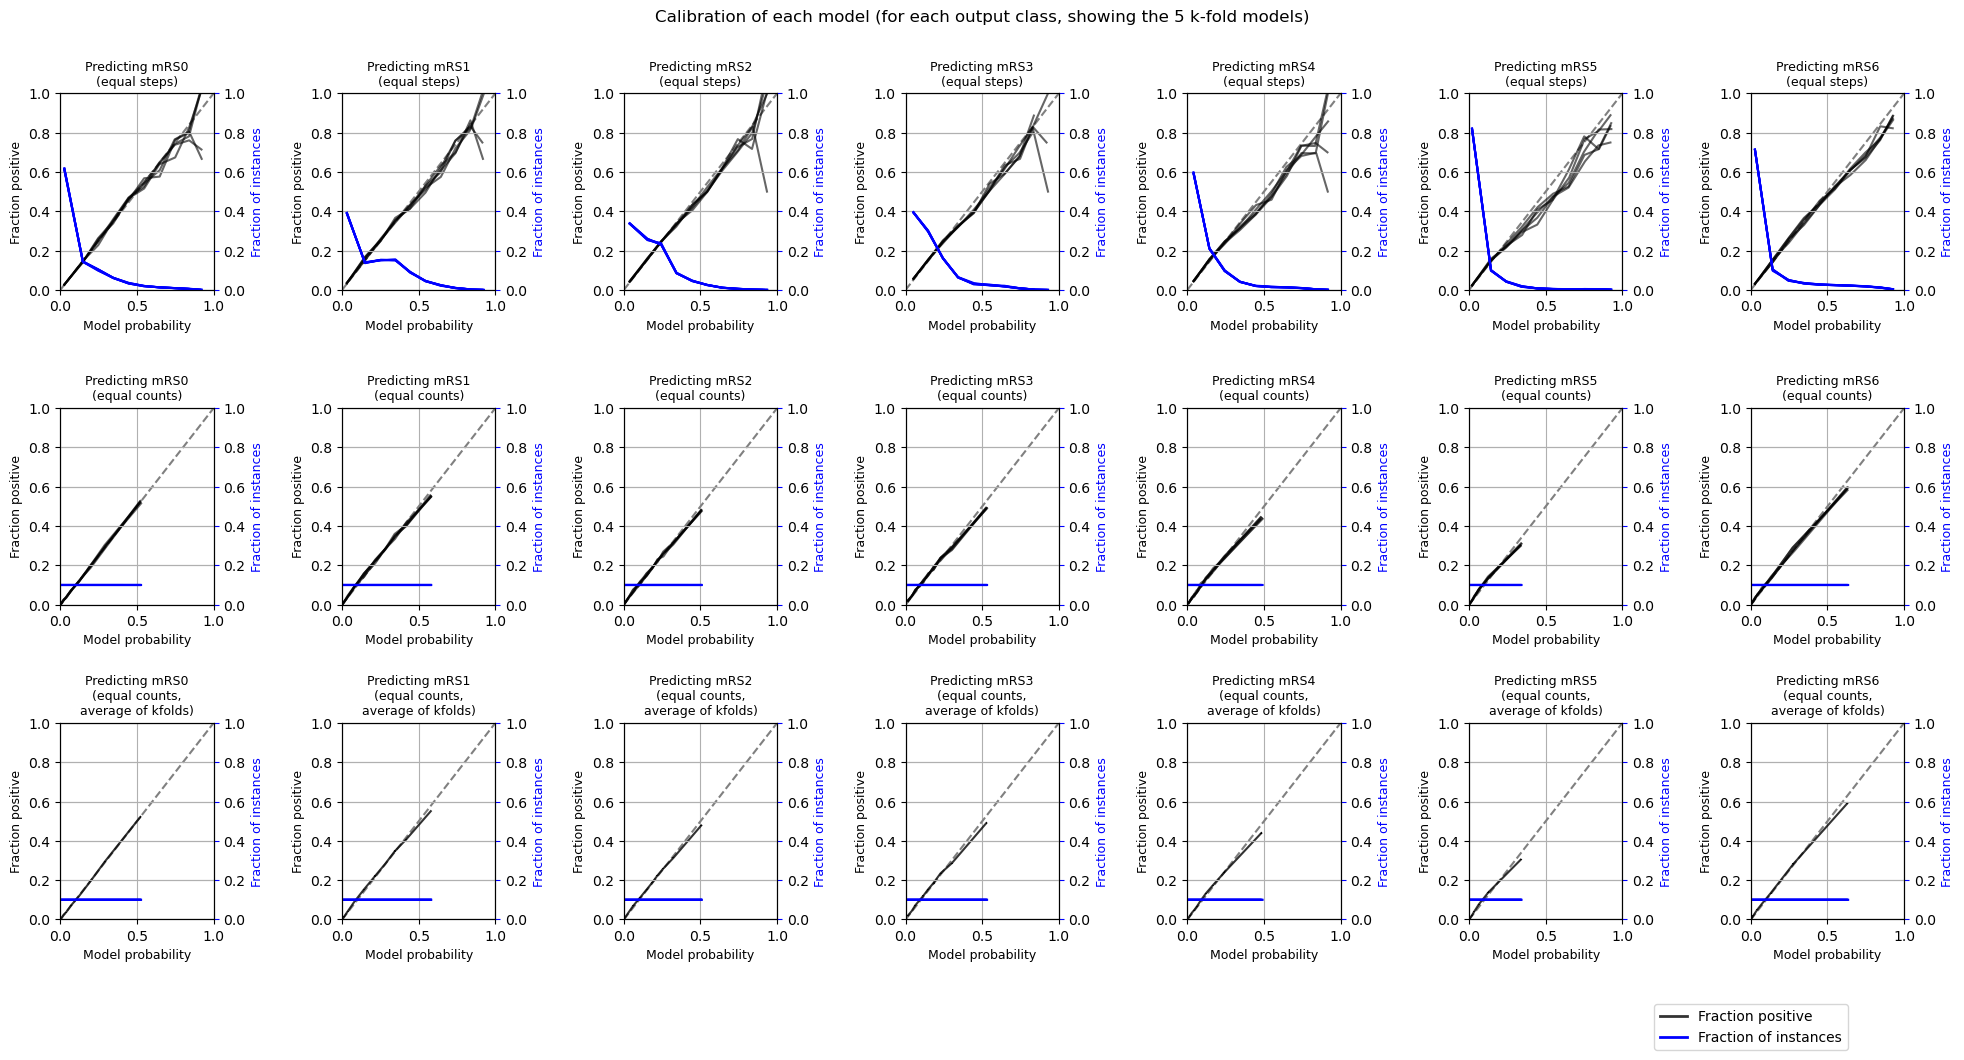

In [99]:
# Setup dictionary to store dataframes of results
dict_results = dict()

fig = plt.figure(figsize=(20,10))

fig.suptitle("Calibration of each model "
             "(for each output class, showing the 5 k-fold models)")

bin_methods = ['steps', 'counts', 'counts,\naverage of kfolds']
n_bin_methods = len(bin_methods)

subplot = 0

# A subplot
for bin_method in bin_methods:

    # Reset column counter
    col = 0

    # loop through the output classes
    for c in class_names:

        # Collate results for each class in a Dataframe (from the different 
        # kfolds)
        reliability_collated = pd.DataFrame()

        # Loop through k fold predictions
        for k in range(n_kfold):

            # Get k fold split
            (X_train, X_test, y_train, y_test) = (
                get_x_y_data(train_data_kfold[k], test_data_kfold[k],
                             'discharge_disability'))

            # Get observed class
            observed = y_test
            
            # And convert to binary for this class (1 = in class, 0 = rest)
            observed_binary = observed == c
    
            # Probability for current class and kfold, for all instances
            prob_observed = y_probs_kfold[k][:,col]

            # Determine the models classification of each instance
            classification = np.argmax(y_probs_kfold[k], axis=1)

            # Depending on bin method, convert prob_observed into bins            
            (bins, digitized) = calculate_bins_digitized(bin_method, 
                                                         prob_observed)

            # Put single fold data in DataFrame
            df_reliability = create_df_reliability(digitized, prob_observed,
                                observed_binary, classification, observed, c)

            # Summarise data by bin in new dataframe
            df_reliability_by_bins = group_data_by_bins(bins,k,df_reliability)

            # Add k-fold results to DataFrame collation
            reliability_collated = reliability_collated.append(
                                                        df_reliability_by_bins)

        # Get probability from next column (for next class)
        col += 1
        subplot += 1

        # Get mean results across kfolds
        reliability_mean_kfolds = reliability_collated.groupby('bin').mean()
        reliability_mean_kfolds.drop('k-fold', axis=1, inplace=True)
    
        # Plot predicted prob vs fraction positive
        ax = fig.add_subplot(n_bin_methods, n_classes, subplot)

        if 'average' in bin_method:
            # pass reliability_mean_kfolds instead ()
            plot_fraction_positive_average(reliability_mean_kfolds, c, ax, 
                                           title_text=f"(equal {bin_method})")
        else:
            plot_fraction_positive(reliability_collated, c, ax, n_kfold, 
                                   title_text=f"(equal {bin_method})")

        # instantiate a second axes that shares the same x-axis
        ax1 = ax.twinx()  

        plot_fraction_instances(reliability_collated, ax1, n_kfold)

        ax.grid()
        ax1.grid()

        plt.tight_layout(pad=2)

        # Store in dictionary
        dict_results[f'reliability_collated_{bin_method}_{c}'] = (
                                                        reliability_collated)
        dict_results[f'reliability_mean_kfolds_{bin_method}_{c}'] = (
                                                        reliability_mean_kfolds)
        
# Only put one legend in figure (bottom left subplot)
custom_lines = [Line2D([0], [0], color='k', alpha=0.8, lw=2),
                Line2D([0], [0], color='blue', lw=2)]

# Place it below x axis a quarter length of y axis
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]

plt.legend(custom_lines, 
            ['Fraction positive', 'Fraction of instances'],
            loc='lower center', 
            bbox_to_anchor=(0,-(y_range * 0.7), 0, 0))


filename = os.path.join(paths.image_save_path, 
                       (paths.notebook + paths.model_text + '_calibration.jpg'))
plt.savefig(filename, dpi=300)

## Section 3: Reliability

What's the accuracy of model, when model is at least a certain threshold confident?

As the model output is softmax (meaning that the sum of all of the class outputs add up to one), if an instance is 50% certain, then it will be classified as this (as no other class could exceed this). Not expecting many to be, as the model splits it's certainty across 7 classes (so an ewqual weighting would be 14%, 1/7).

For example, look at the model predicting if an instance is each class: How many instances is the model 50% certain that the instance is that class?

Choosing any threshold to see the performance of the model at this level of confidence.

In [100]:
threshold = 0.5
col = 0

# Initialise lists. 
# For each class, store fraction of instances that the model is this certain
list_frac_certain_per_class = []
# For each class, store model accuracy for these instances
list_accuracy_of_these_per_class = []

for c in class_names:
    # Collate results for each class in a Dataframe
    reliability_collated = pd.DataFrame()

    # Loop through k fold predictions
    for k in range(5):

        # Get k fold split
        (X_train, X_test, y_train, y_test) = get_x_y_data(
                                                    train_data_kfold[k],
                                                    test_data_kfold[k],
                                                    'discharge_disability')

        # Get observed class
        observed = y_test
        # And convert to binary for this class (1 = in class, 0 = rest)
        observed_binary = observed == c

        # Probability for current class and kfold, for all instances
        prob_observed = y_probs_kfold[k][:,col]
        # Determine the models classification of each instance
        classification = np.argmax(y_probs_kfold[k], axis=1)
        
        # Put instances in bin (either less than, or greater than threshold)
        bins = [threshold, 1.0]
        digitized = np.digitize(prob_observed, bins)

        # Put this single kfold data in DataFrame, row per instance
        df_reliability = create_df_reliability(digitized, prob_observed,
                                observed_binary, classification, observed, c)

        # Group instances by bins
        df_reliability_by_bins = group_data_by_bins(bins, k, df_reliability)

        # Add k-fold results to DataFrame collation
        reliability_collated = reliability_collated.append(
                                                    df_reliability_by_bins)
    # Get mean results for each bin across kfolds
    reliability_mean_kfolds = reliability_collated.groupby('bin').mean()
    reliability_mean_kfolds.drop('k-fold', axis=1, inplace=True)

    # bin_for_threshold
    bin_for_threshold = 1.0
    frac = reliability_mean_kfolds.loc[bin_for_threshold]['fraction_results']
    acc = reliability_mean_kfolds.loc[bin_for_threshold]['fraction_correct']

    list_frac_certain_per_class.append(frac)
    list_accuracy_of_these_per_class.append(acc)
    
    col += 1

In [101]:
def create_lists(threshold, n_kfold, class_names, train_data_kfold, 
                 test_data_kfold):
    """
    Create, and return, two lists


    Args:
        threshold [float]: threshold to divide data into bin
        n_kfold [integer]: number of kfolds
        class_names [list]: list of class names
        train_data_kfold [list]: a list of dataframes containing the training 
                    data for each kfold
        test_data_kfold [list]: a list of dataframes containing the test 
                    data for each kfold

    Return:
        list_accuracy_of_these_per_class []:
        list_frac_certain_per_class []:

    """
    col = 0

    # Initialise lists. 
    # For each class, store fraction of instances that the model is this certain
    list_frac_certain_per_class = []
    # For each class, store model accuracy for these instances
    list_accuracy_of_these_per_class = []

    for c in class_names:
        # Collate results for each class in a Dataframe
        reliability_collated = pd.DataFrame()

        # Loop through k fold predictions
        for k in range(n_kfold):

            # Get k fold split
            (X_train, X_test, y_train, y_test) = get_x_y_data(
                                                        train_data_kfold[k],
                                                        test_data_kfold[k],
                                                        'discharge_disability')

            # Get observed class
            observed = y_test
            # And convert to binary for this class (1 = in class, 0 = rest)
            observed_binary = observed == c

            # Probability for current class and kfold, for all instances
            prob_observed = y_probs_kfold[k][:,col]
            # Determine the models classification of each instance
            classification = np.argmax(y_probs_kfold[k], axis=1)
            
            # Put instances in bin (either less than, or greater than threshold)
            bins = [threshold, 1.0]
            digitized = np.digitize(prob_observed, bins)

            # Put this single kfold data in DataFrame, row per instance
            df_reliability = create_df_reliability(digitized, prob_observed,
                                    observed_binary, classification, observed, c)

            # Group instances by bins
            df_reliability_by_bins = group_data_by_bins(bins, k, df_reliability)

            # Add k-fold results to DataFrame collation
            reliability_collated = reliability_collated.append(
                                                        df_reliability_by_bins)
        # Get mean results for each bin across kfolds
        reliability_mean_kfolds = reliability_collated.groupby('bin').mean()
        reliability_mean_kfolds.drop('k-fold', axis=1, inplace=True)

        # bin_for_threshold
        bin_for_threshold = 1.0
        frac = reliability_mean_kfolds.loc[bin_for_threshold]['fraction_results']
        acc = reliability_mean_kfolds.loc[bin_for_threshold]['fraction_correct']

        list_frac_certain_per_class.append(frac)
        list_accuracy_of_these_per_class.append(acc)
        
        col += 1

    return(list_accuracy_of_these_per_class, list_frac_certain_per_class)

Average across the kfolds, plotting for each class the proportion of instances that the model is that confident about, and for those how many the model is correct on.

In [102]:
def plot_reliability_chart(threshold, class_names, 
                           list_accuracy_of_these_per_class, 
                           list_frac_certain_per_class, ax):
    """
    Create a reliability plot: accuracy (and proportion) vs discharge 
    disability

    Only include patients that have atleast a specified certainty.

    Args:
        threshold []:
        class_names []:
        list_accuracy_of_these_per_class []:
        list_frac_certain_per_class []:
        ax []:

    Return:
        None

    """

    plt.title(f'Instances with at least {int(threshold * 100)}% '
            f'confidence from model')
        
    ax.plot(class_names, list_accuracy_of_these_per_class, color='darkorange', 
            linewidth=3)
    # Refine plot
    ax.set_xlabel('Discharge disability (mRS)')
    ax.set_ylabel(f'Accuracy for instances with > {int(threshold * 100)}% '
                f'confidence', color='xkcd:pumpkin', fontsize=8)
    ax.set_ylim((0,1))
    # instantiate a second axes that shares the same x-axis
    ax1 = ax.twinx()  
    ax1.plot(class_names, list_frac_certain_per_class, color='blue', 
             linewidth=3)
    ax1.set_ylabel(f'Proportion of instances with > {int(threshold * 100)}% '
                f'confidence', color='blue', fontsize=8)
    ax1.set_ylim((0,1))
            

    custom_lines = [Line2D([0], [0], color='darkorange', alpha=0.6, lw=2),
                    Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

    ax.grid()
    ax1.grid()

    plt.tight_layout()

    return()

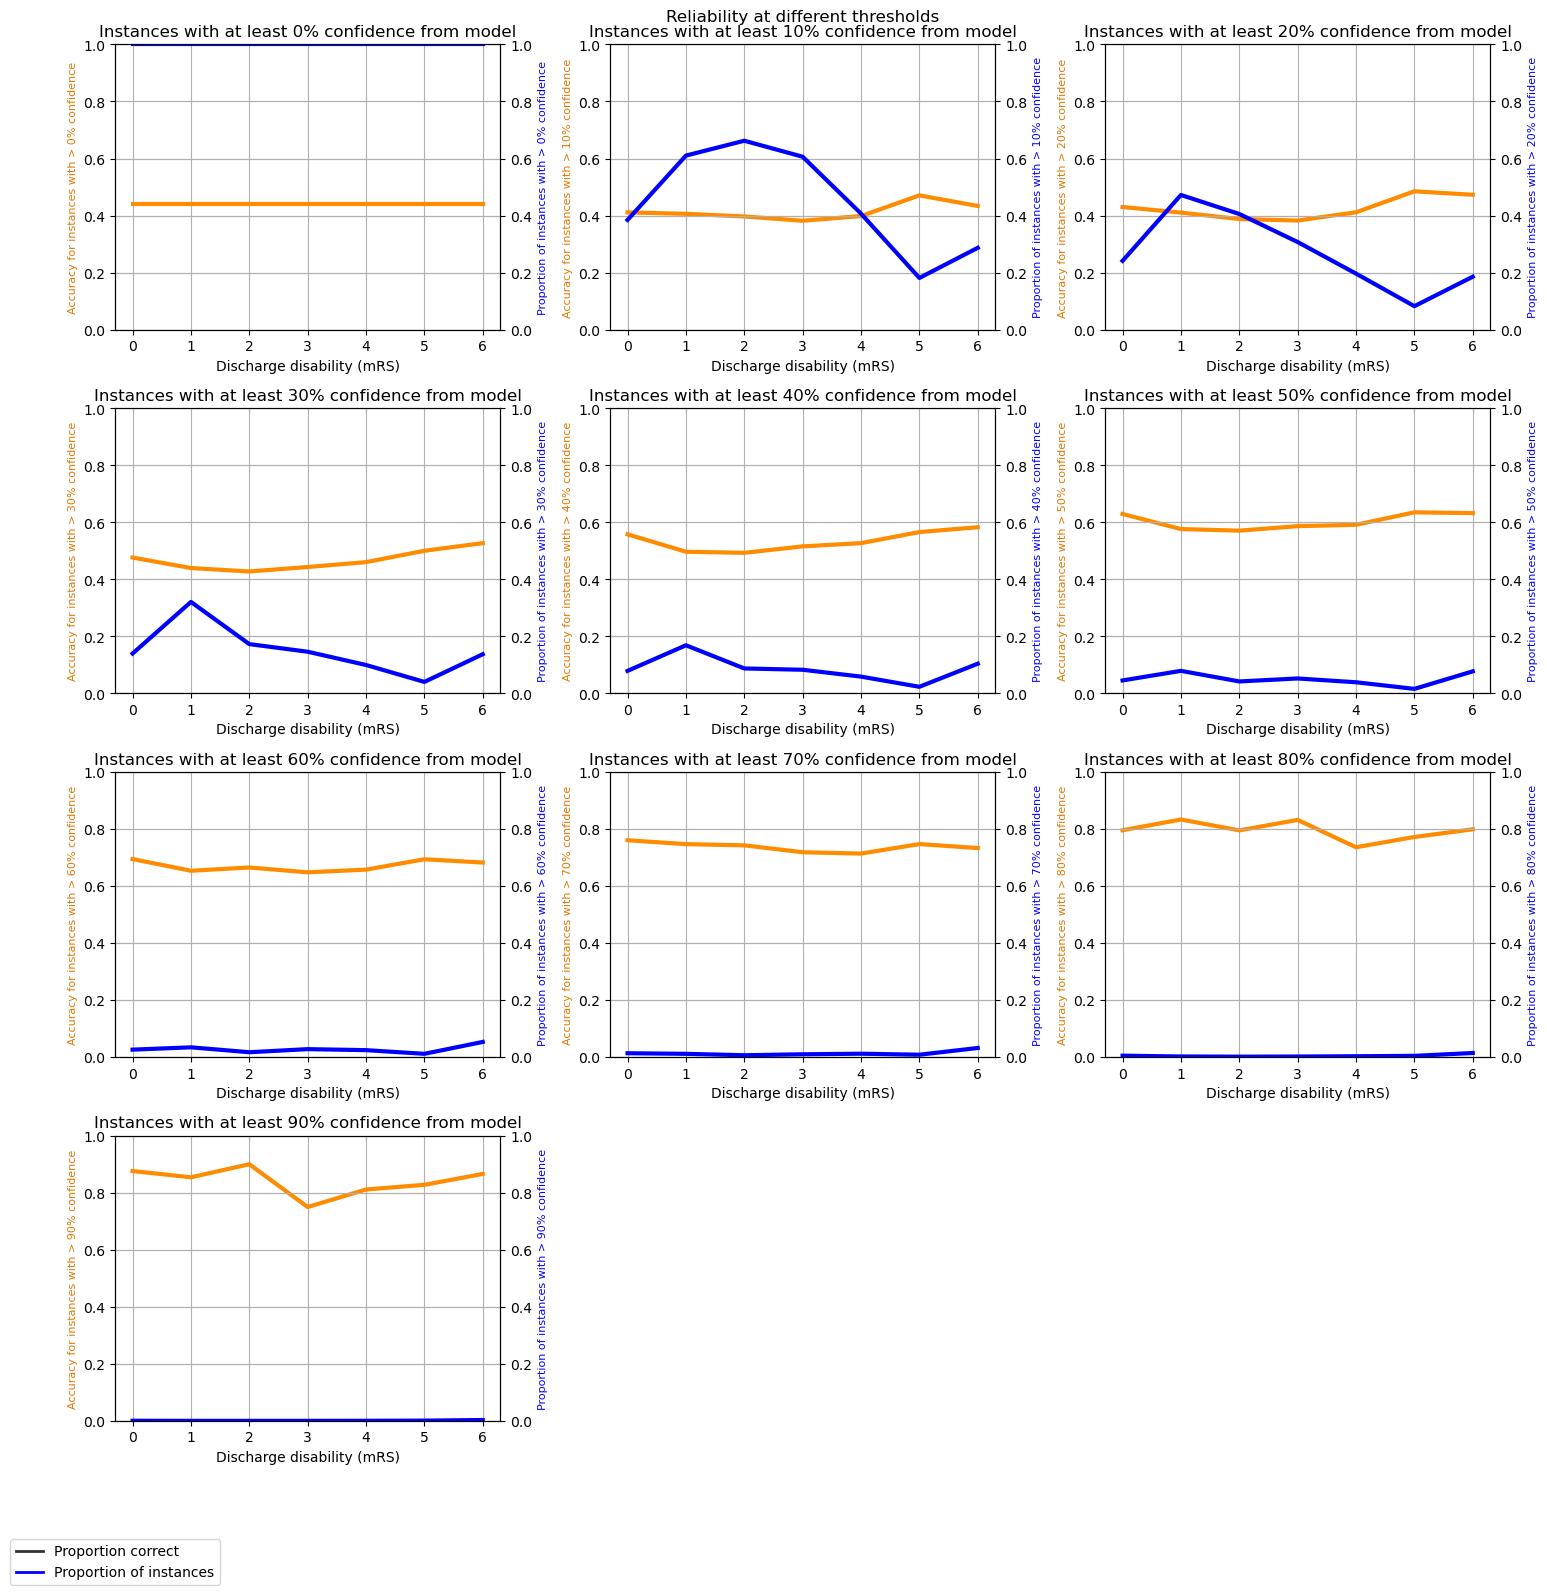

In [103]:
fig = plt.figure(figsize=(15,15))

fig.suptitle("Reliability at different thresholds")

thresholds = list(range(0,10,1))
thresholds = [x/10 for x in thresholds]

n_cols = 3
n_rows = int((len(thresholds)/n_cols) + 0.99)

for i, threshold in enumerate(thresholds):
    # Plot accuracy vs probability
    ax = fig.add_subplot(n_rows,n_cols,i+1)

    (list_accuracy_of_these_per_class, list_frac_certain_per_class) = (
                create_lists(threshold, n_kfold, class_names, 
                        train_data_kfold, test_data_kfold))
    
    plot_reliability_chart(threshold, class_names, 
                           list_accuracy_of_these_per_class, 
                           list_frac_certain_per_class, ax)

# Make space for title
#plt.subplots_adjust(top=0.5)

plt.legend(custom_lines, ['Proportion correct', 'Proportion of instances'],
            loc='lower center', 
            bbox_to_anchor=(0,-(y_range * 0.6), 0, 0))
plt.show()

Duration to run notebook

In [104]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'1:35:12.720822'

***** End of main notebook *****

## Extra analysis

Code here so as to not clog up the main notebook flow (but could be useful extra visualisations)

### ROC Curve - One vs One (OvO)

Compares each possible combination of the classes, two at a time.

As this is run for each kfold, this is a lot of output. Here show it just for the first kfold (and use the analysis in the notebook looking at one vs rest for the kfold consistency analysis)

In [105]:
classes_combinations = []
for i in range(n_classes):
    for j in range(n_classes):
        if i != j:
            classes_combinations.append([i, j])

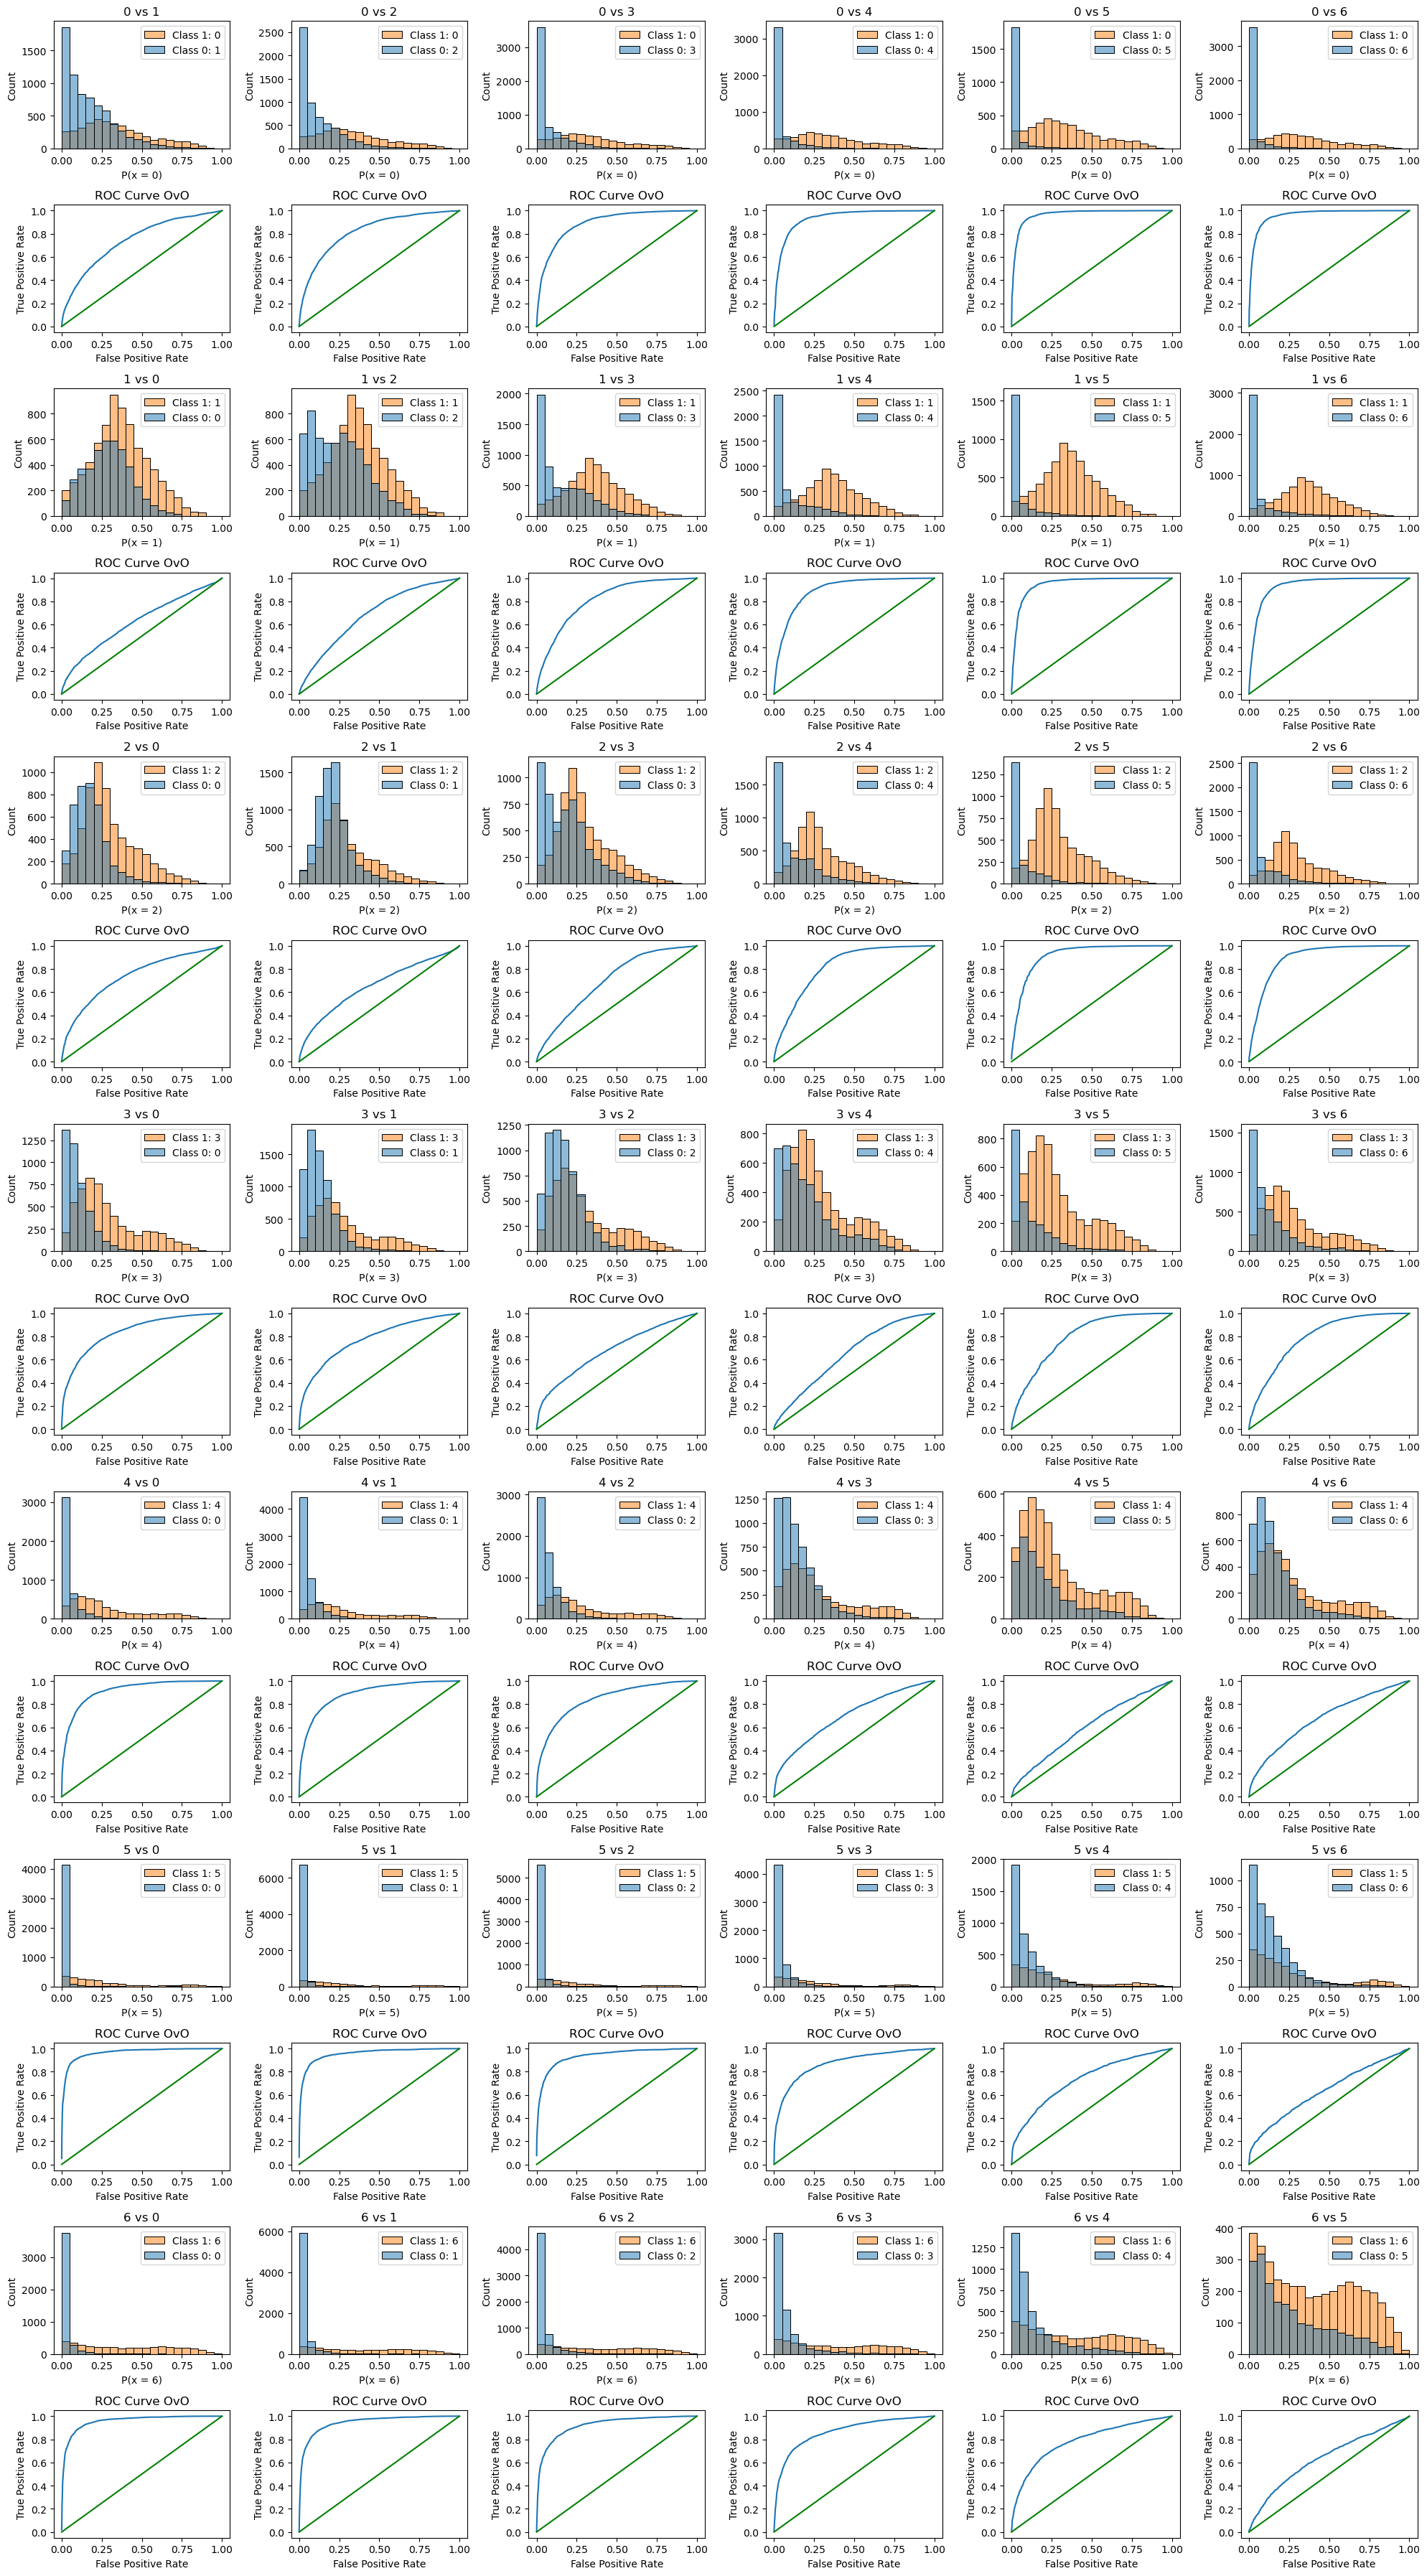

In [106]:
k = 0

# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                    test_data_kfold[k],
                                                    'discharge_disability')

# Plots the Probability Distributions and the ROC Curves One vs ONe
fig_height = 6 * (n_classes-1)

plt.figure(figsize = (20, fig_height))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

# For subplot placement
col_top = 0
group_count = 0

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = np.where(class_names == c1)[0][0]
    title = str(c1) + " vs " + str(c2)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame()#X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_probs_kfold[k][:, c1_index]
    
    # Slices only the subset containing either classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]

    # Fill column 'class' with 1 if instance is c1, or 0 if instance is c2
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    group_count += 1
    col_top += 1
    if group_count == (n_classes):
        group_count = 1
        col_top = col_top + (n_classes-1)
        
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2*n_classes, n_classes-1, col_top)
    sns.histplot(x="prob", data=df_aux, hue='class', color='b', ax=ax, 
                 bins=bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    col_bottom = col_top + (n_classes-1)
    ax_bottom = plt.subplot(2*n_classes, n_classes-1, col_bottom)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax=ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                paths.model_text + '_rocauc_heatmap_kfold' + str(k) + '.jpg'))
plt.savefig(filename, dpi=300)

To interpret these OvO graphs, look at the x axis to see which category the probability is being shown for. Orange shows the instances that have that classification. Blue shows the instances that have another classification (as shown on the title or legend).

The better the model determines the difference between these two classes, the more separate the two histogram (orange to the right - many instances close to probability of 1, with blue to the left - many instances with a probability close to 0)

Top left graph narrative: Showing the probability of being class 0. Orange show range of probabilities to be 0 for those instances that are 0. Blue show range of probabilities to be 0 for those instances that are 1.

Bottom gright graph narrative: Showing the probability of being class 6. Orange show range of probabilities to be 6 for those instances that are 6. Blue show range of probabilities to be 6 for those instances that are 5.

Show the ROC AUC for the OvO as a heat map.
First prepare the data

In [107]:
roc_auc_ovo_array = np.empty((n_classes, n_classes), dtype=object)

# Displays the ROC AUC for each class
for k in roc_auc_ovo:
    roc_auc_ovo_array[int(k[0]),int(k[-1])] = roc_auc_ovo[k]

# No entry for diagonal, fill with zero
np.fill_diagonal(roc_auc_ovo_array, 0)

# Convert to flaot
roc_auc_ovo_array = roc_auc_ovo_array.astype(float)

Plot the ROCAUC heatmap
The placement is the output class, the value is how well the model classifies the correct class from one other class.

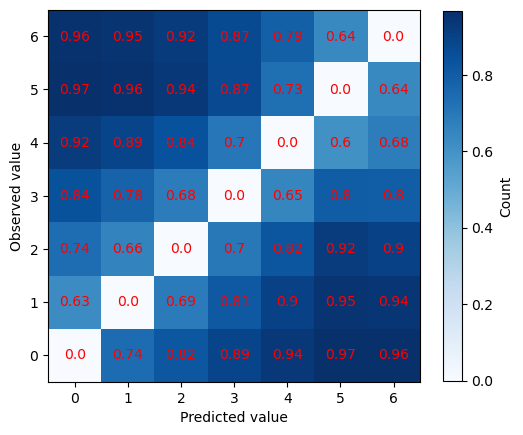

In [108]:
# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(roc_auc_ovo_array, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(roc_auc_ovo_array)):
    for j in range(len(roc_auc_ovo_array[0])):
        plt.text(j, i, roc_auc_ovo_array[i][j].round(2), ha='center', 
                 va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

Duration to run notebook

In [ ]:
str(datetime.timedelta(seconds=(time.time()-start_time)))